# Introduction

The increasing abundance and complexity of biological data often requires programatic approaches for their analysis that allow for the rapid development of custom yet efficient, well-tested and reproducible analysis pipelines. 

Traditional approaches (e.g., bash command/perl pipelines), that suffer from low readability, maintainability and reproducibility,
are increasingly superseded by complex, containerized (e.g., Singularity) analysis pipelines that combine specialized bioinformatics tools 
with custom scripts developed in higher programming languages such as *Python*, *R* or *Rust*.

Despite not being the fastest option, *Python* is a [popular choice by analysts](https://github.blog/2023-03-02-why-python-keeps-growing-explained/), mainly due to the large number of available (bioinformatics) libraries, its simple and well-documented syntax and its broad utility in the emerging data science field.

For this reason an increasing number of python APIs for the handling of genomics data are being developed. 
While some are mainly wrappers around well-established bioinformatics tools (e.g., pysam/samtools, pybedtools/BEDTools or cyvcf2/htslib) others are builing on efficient data wrangling/analysis libraries such as *pandas* or *numpy* (e.g., bioframe/pandas, pyranges/pandas, bionumpy/numpy).

Here, we present *pygenlib*, a python utilities library for handling genomics data with a focus on transcriptomics and compare it to 
a number of related APIs with regard to provided features and performance. We additionally demonstrate some common analysis pitfalls that 
we tried to address in the design of our library.

Finally, we showcase how the combination of (the strengths of) multiple genomics libraries leads to an overall benefit.


In [63]:
# set path and  load pygenlib
import os, pathlib, platform
PYGENLIB_SRC='/Users/niko.popitsch/git/pygenlib/'  #'/groups/ameres/Niko/workspace/pygenlib/' # '/Users/niko.popitsch/git/pygenlib/' 
os.chdir(PYGENLIB_SRC)
# install libraries. Recommended to run in a venv here!
#!{sys.executable} -m pip install -r requirements.txt 
display(f"Running pygenlib on python {platform.python_version()}. Using pygenlib code from {PYGENLIB_SRC}")
# load libs
from IPython.display import Markdown
from Bio.Seq import Seq
import matplotlib.pyplot as plt
from pygenlib.utils import *
from pygenlib.iterators import *
from pygenlib.genemodel import *
from pygenlib.testdata import get_resource, list_resources, make_random_intervals
from itertools import islice
import pprint

import pandas as pd
import numpy as np
import pprint
import pybedtools 
import bioframe
import tempfile
import pytest
import dataclasses

# helper methods
SEP=Markdown('---')
from IPython.display import display, HTML
def display_textarea(txt):
    """ Display a (long) text in a scrollable HTML text area """
    display(HTML(f"<textarea rows='4' cols='120'>{txt}</textarea>"))
def head_counter(cnt, non_empty=True):
    """Displays n items from the passed counter. If non_empty is true then only items with len>0 are shown"""
    if non_empty:
        cnt=Counter({k: ac1.get(k, 0) for k in ac1.keys() if len(ac1.get(k))>0})
    display(Counter({k:v for k,v in islice(cnt.items(),1,10)}), "[...]")
def plot_times(title, times, n=None, 
               our_method='pygenlib_iter', 
               show_speed=True,
               ax=None
              ):
    """ Helper method to plot the timings """
    ax = ax or plt.gca()
    labels, values = zip(*sorted(times.items()))
    if show_speed:
        values=[n/v for v in values]
        speed_fastest = n/min(times.values())
        speed_our_method = n/times[our_method]
        ax.set_title(f"{title}\nThe fastest method is {(speed_fastest/speed_our_method-1)*100}%\nfaster than {our_method}", fontsize=10)
        ax.set_ylabel("it/s")
    else:
        ax.set_title(f"{title}")
        ax.set_ylabel("seconds")
    ax.bar(range(len(labels)), values, 0.8)
    ax.set_xticks(range(len(labels)), labels, rotation=90)
    #display(f"For iterating+filtering {n} items, The fastest method ({speed_fastest} it/s) is {speed_fastest/speed_our_method}X")
    #display(f"({(speed_fastest/speed_our_method-1)*100}%) faster than pygenlib ({speed_our_method} it/s).")
    #return(fig)

'Running pygenlib on python 3.10.4. Using pygenlib code from /Users/niko.popitsch/git/pygenlib/'

# Pygenlib

Pygenlib is a python utilities library for handling genomics data with a focus on transcriptomics. 
It is roughly structured into the following modules:

- [genemodel](#Transcriptome): python classes for modeling genomics (annotation) data. This includes a '[transcriptome](#Transcriptome)' implementation that models gene/transcript annotations and many useful querying/annotation methods.
- [iterators](#Iterators): efficient iteration over large-scaled genomics datasets. Iterators keep track of the genomic region of the
  yielded data enabling their efficient integration with other genomics data
- [utils](#Utility-functions): general (low-level) utility functions for working with genomics datasets.


Pygenlib implements a transcriptome data model that preserved parent/child relationships between features (e.g., transcripts and introns) and a secure way for annotating such features by structuring them into immutable genomic locations (that can, e.g., safely be used in lookup tables) and mutatble, arbitrary annotations. 


Transcriptomics analyses require the integration of various biological data sources (e.g., gene/transcript annotations, sequence alignment data, genomic scores, etc.) which is why pygenlib implement variour genomic iterators on top of existing python implementations (pysam, bioframe, pybedtools).

This ipython notebook demonstrates some of pygenlib's functionality and API using simple and complex access examples. Please also refer to pygenlib's test classes for further API examples.

Note that this notebook uses various genomics data test files that can be accessed via the `pygenlib.testdata.get_resource('<test_resource_id'>` method. See the testdata.py class for details how these files were created.


## Genomic intervals
Genomic regions and positions are referenced by the  *genomic intervals* (gi) class in pygenlib:
- Genomic intervals (gi) in pygenlib are inclusive and 1-based. 
- GIs are implemented as frozen (pseudo immutable) dataclasses and can thus be used, e.g., as keys in a dict.
- GIs can be instantiated by passing chrom/start/stop coordinates or can be parsed form a string. 
- GIs can be stranded. Unstranded intervals are represented by setting strand to None (default) 
- Using None for each component of the coordinates is allowed to represent unbounded intervals. Examples:
  - gi('chr1') refers to the whole chromosome
  - gi('chr1', 100000) refers to the section of chromosome 1 from (and including) positon 100k on.
  - gi(start=100, end=200) refers to positions 100-200 (inclusive) on any chromosome 
- Points are represented by GIs with same start and end coordinate.
- Empty intervals are represented by GIs with start>end coordinates (experimental)

Chromosome order in a genome is represented by *ReferenceDict*s (which extend regular python dicts).
- ReferenceDicts can be used to properly sort genomic intervals (see example below)
- ReferenceDicts keep track of the available chromosomes and their length and are typically directly derived from genomic data files
- ReferenceDicts are used in pygenlib to check for compatibility of different genomic datasets

More documentation can be accessed via
`help(gi)`

In [64]:
# create a list of genomic intervals
locs=[gi('chr2', 1, 100), # chr2:1-100, unstranded
      gi.from_str('chr1:5-500 (+)'),  # parsed from string, strand='+'
      gi.from_str('chr3:50-120 (-)'), 
      gi.from_str('chr1:10-20 (-)'), 
      gi(None, None, 1000, '-'), # chromosome and start unbound, end=1000, strand='-'
      gi(None, 10, 1000, '-')] # chromosome unbound
display('Sorted by start coordinate but order of chromosomes is undefined:', sorted(locs), SEP)

# Note that chromosome group intervals and the order of intervals from different groups (chromosomes) is left undefined.
display(f"Is the greater-than comparison chr2:1-1>chr1:1-1 defined? {gi('chr2', 1, 1) > gi('chr1', 1, 1)}", SEP)

# To sort also by chromosome, you can use a reference dict which defined the chromosome order:
refdict=ReferenceDict({'chr1':None, 'chr2':None, 'chr3':None}, 'test', None)
display(refdict, SEP)
display('Properly sorted list:', sorted(locs, key=lambda x: (refdict.index(x.chromosome), x)))
# Unbounded intervals (chromosome=None) will always be at the beginning of the list

'Sorted by start coordinate but order of chromosomes is undefined:'

[None:-inf-1000 (-),
 chr2:1-100,
 chr1:5-500 (+),
 chr3:50-120 (-),
 chr1:10-20 (-),
 None:10-1000 (-)]

---

'Is the greater-than comparison chr2:1-1>chr1:1-1 defined? None'

---

Refset (size: 3): dict_keys(['chr1', 'chr2', 'chr3']), dict_values([None, None, None]) name: test 

---

'Properly sorted list:'

[None:-inf-1000 (-),
 None:10-1000 (-),
 chr1:5-500 (+),
 chr1:10-20 (-),
 chr2:1-100,
 chr3:50-120 (-)]

## Iterators

_pygenlib_ implements several *LocationIterator*s for efficient iteration over (parts of) genomics datasets while keeping track of the [genomic interval](#Genomic-intervals) each yielded item refers to. Most implemented iterators are based on respective [pysam](https://pysam.readthedocs.io/en/latest/api.html) classes but extend them with different filtering/access methods and add sanity checks to avoid common errors when combining different genomics datasets.

The primary goal of LocationIterators is to support the synchronization/integration of different genomics datasets. LocationIterators also support chunked I/O where feasible and not supported by the underlying (pysam) implementation.

LocationIterators can iterate whole datasets or specific sub-region (e.g., a certain chromosome or genomic region). Yielded data items are sorted by respective [genomic intervals](#Genomic-intervals) where the order of chromosomes is defined by a [ReferenceDict](#Genomic-intervals) that is derived directly from the iterated dataset (e.g., by querying it's tabix index). When multiple LocationIterators are integrated (e.g., by an AnnotationIterator), their ReferenceDicts are checked for compatibility.

Sometimes, genomics datasets from different providers used differing chromosome ids to refer to the same chromosomes which hinders their integration. 
Location iterators support chromosome aliasing as a quick solution for this: users can provide aliasing functions (e.g., for adding/removing 'chr' prefixes from 
chromosome ids) to dynamically change chromosome ids while keeping the underlying data files untouched.

Implemented LocationIterators include:
* [FastaIterator](#FastaIterator): iterates FASTA files per position or genomic window (e.g., Tiling/sliding windows).
* [FastqIterator](#FastqIterator): iterates FASTQ entries (NOTE that this is no LocationIterator)
* [GFF3Iterator](#GFF3Iterator): iterates GTF/GFF3 files and parses annotation data. Used for the [Transcriptome](#transcriptome) implementation
* [ReadIterator](#ReadIterator): iterates SAM/BAM files and implements various filter options. 
* [FastPileupIterator](#FastPileupIterator): a faster alternative to pysam's pileup method
* [VcfIterator](#AnnotationIterator): iterates VCF files and can filter for samples
* [AnnotationIterator](#AnnotationIterator): annotates the items from one LocationIterator with items from others

and many more.
The following sections showcase some of the implemented iterators:

### FastaIterator
Iterates over a FASTA file but enables also tiling/sliding windows and padding.

In [4]:
# FastaIterator that supports window/step size and padding
fasta_file=get_resource('ACTB+SOX2_genome')

# get 5mer sliding windows (step size 2) with padding from a GRCh38 chr7 region around ACTB; show first and last 5 results
# <it>.take() consumes the whole iterator and stores the items in a list.
# item.data returns the data item returned by this iterator (here: a string containing the kmer)
# item.location is a GI describing the genomic location of this sequence
kmers=[item.data for item in FastaIterator(get_resource('ACTB+SOX2_genome'), 
                                           'chr7', None, None, # iterate only over chr7
                                           width=5, # report 5-mers
                                           step=2,  # step size: 2
                                           padding=True) # pad with N's at the sequence boundaries
       .take()] # take consumes all items from the iterator; this is useful for small tests
display(f"{kmers[:5]}...{kmers[-5:]}")

"['NNTTG', 'TTGTG', 'GTGCC', 'GCCAT', 'CATTA']...['TTGTA', 'GTATT', 'ATTTT', 'TTTTN', 'TTNNN']"

### FastqIterator
Iterates over a FASTQ file and returns named tuples (name seq qual) containing read names, sequence and quality strings

In [5]:
# iterate over PE reads in two FASTQ files and display their read names and sequence lengths
for r1,r2 in zip(FastqIterator(get_resource('small_PE_fastq1')), FastqIterator(get_resource('small_PE_fastq2'))):
    display(f"{r1.name}, {r2.name}")
    display(f"{len(r1.seq)}, {len(r2.seq)}")

'@M01558:94:000000000-B4PB4:1:1101:16988:1392 1:N:0:20, @M01558:94:000000000-B4PB4:1:1101:16988:1392 2:N:0:20'

'251, 250'

'@M01558:94:000000000-B4PB4:1:1101:16905:1394 1:N:0:20, @M01558:94:000000000-B4PB4:1:1101:16905:1394 2:N:0:20'

'251, 251'

'@M01558:94:000000000-B4PB4:1:1101:16922:1403 1:N:0:20, @M01558:94:000000000-B4PB4:1:1101:16922:1403 2:N:0:20'

'251, 250'

'@M01558:94:000000000-B4PB4:1:1101:15249:1404 1:N:0:20, @M01558:94:000000000-B4PB4:1:1101:15249:1404 2:N:0:20'

'251, 250'

'@M01558:94:000000000-B4PB4:1:1101:15251:1423 1:N:0:20, @M01558:94:000000000-B4PB4:1:1101:15251:1423 2:N:0:20'

'251, 250'

### GFF3Iterator
Iterates over GFF3 files and yields dicts containing parsed annotation fields.

In [6]:
# Show two data items from a GFF3 file
display(GFF3Iterator(get_resource('gencode_gff')).take()[:2])

# iterate whole GFF3 file and collect stats of contained feature_type annotations
Counter([item.data['feature_type'] for item in GFF3Iterator(get_resource('gencode_gff'))])

[Item(location=chr3:180989762-181836880 (+), data={'ID': 'ENSG00000242808.12', 'gene_id': 'ENSG00000242808.12', 'gene_type': 'lncRNA', 'gene_name': 'SOX2-OT', 'level': '2', 'hgnc_id': 'HGNC:20209', 'tag': 'ncRNA_host,overlapping_locus', 'havana_gene': 'OTTHUMG00000158186.13', 'feature_type': 'gene', 'source': 'HAVANA', 'score': None, 'phase': None}),
 Item(location=chr3:180989770-181791029 (+), data={'ID': 'ENST00000626948.3', 'Parent': 'ENSG00000242808.12', 'gene_id': 'ENSG00000242808.12', 'transcript_id': 'ENST00000626948.3', 'gene_type': 'lncRNA', 'gene_name': 'SOX2-OT', 'transcript_type': 'lncRNA', 'transcript_name': 'SOX2-OT-240', 'level': '2', 'transcript_support_level': '5', 'hgnc_id': 'HGNC:20209', 'tag': 'nested_454_RNA_Seq_supported,basic,Ensembl_canonical,TAGENE', 'havana_gene': 'OTTHUMG00000158186.13', 'havana_transcript': 'OTTHUMT00000481527.1', 'feature_type': 'transcript', 'source': 'HAVANA', 'score': None, 'phase': None})]

Counter({'exon': 108,
         'transcript': 89,
         'CDS': 60,
         'five_prime_UTR': 33,
         'three_prime_UTR': 20,
         'start_codon': 17,
         'stop_codon': 13,
         'gene': 5})

### ReadIterator
Iterates SAM/BAM files and implements several filter options. Also keeps track of how many reads were filtered for what reason.
Can also yield mismatches wrt. the reference if MD tags are available (can be added, e.g., by [samtools calmd](http://www.htslib.org/doc/samtools-calmd.html) if not added by the mapper itself).


In [7]:
# count reads per chromosome in a BAM using different filters
stats={x:Counter() for x in ['all', 'def', 'mq20', 'tag']}
with open_file_obj(get_resource('small_example_bam')) as bam:
    for chrom in get_reference_dict(bam):
        with ReadIterator(bam, chrom, flag_filter=0) as it: # all: no filtering
            it.take()
            stats['all'].update(it.stats)
        with ReadIterator(bam, chrom) as it: # def: default flag filter (as in IGV)
            it.take()
            stats['def'].update(it.stats)
        with ReadIterator(bam, chrom, min_mapping_quality=20) as it: # mq20: default flag filter, mapping quality >= 20
            it.take()
            stats['mq20'].update(it.stats)
        with ReadIterator(bam, chrom, tag_filters=[TagFilter('MD', ['100'])]) as it: # tag: default flag filter, MD tag must be '100'
            it.take()
            stats['tag'].update(it.stats)
display(stats)

{'all': Counter({('iterated_items', '1'): 31678,
          ('yielded_items', '1'): 31678}),
 'def': Counter({('iterated_items', '1'): 31678,
          ('yielded_items', '1'): 21932,
          ('n_fil_flag', '1'): 9746}),
 'mq20': Counter({('iterated_items', '1'): 31678,
          ('yielded_items', '1'): 21626,
          ('n_fil_flag', '1'): 9746,
          ('n_fil_mq', '1'): 306}),
 'tag': Counter({('iterated_items', '1'): 31678,
          ('n_fil_tag', '1'): 14544,
          ('n_fil_flag', '1'): 9746,
          ('yielded_items', '1'): 7388})}

#### Splitting large datasets
A common practice of many genomics applications is to break up analyses into continuous blocks (genomic intervals or tiles), e.g., to parallelize computation or just to deal with large datasets. Splitting a reference dict (i.e., a genome representation) into such blocks can easily be done using its `iter_blocks()` method. Iterating over a large BAM file, handling non-overlapping genomic intervals, for example, can be done as follow:

In [8]:
stats=Counter()
with open_file_obj(get_resource('small_example_bam')) as bam:
    # we iterate of blocks (genomic intervals) with a maximum size of 100Mio bases
    for block in get_reference_dict(bam).iter_blocks(int(1e8)):
        # This BAM file was mapped to a GRCh37 version with chromosome names that were not prefixed by 'chr'.
        # Here, we add this 'chr' prefix and then check whether this is a canonical chromosome name (chr1-22,X,Y,M)
        if toggle_chr(block.chromosome) in canonical_chromosomes['GRCh38']:
            # now we iterate over all reads overlapping with a block annd count the reads
            with ReadIterator(bam, region=block, flag_filter=0) as it: # all: no filtering                
                # here we record the considered genomic interval (block) and the number of iterated reads
                stats[str(block)]=len(it.take())
display(stats)

Counter({'1:1-100000000': 31678,
         '1:100000001-200000000': 0,
         '1:200000001-249250621': 0,
         '2:1-100000000': 0,
         '2:100000001-200000000': 0,
         '2:200000001-243199373': 0,
         '3:1-100000000': 0,
         '3:100000001-198022430': 0,
         '4:1-100000000': 0,
         '4:100000001-191154276': 0,
         '5:1-100000000': 0,
         '5:100000001-180915260': 0,
         '6:1-100000000': 0,
         '6:100000001-171115067': 0,
         '7:1-100000000': 0,
         '7:100000001-159138663': 0,
         '8:1-100000000': 0,
         '8:100000001-146364022': 0,
         '9:1-100000000': 0,
         '9:100000001-141213431': 0,
         '10:1-100000000': 0,
         '10:100000001-135534747': 0,
         '11:1-100000000': 0,
         '11:100000001-135006516': 0,
         '12:1-100000000': 0,
         '12:100000001-133851895': 0,
         '13:1-100000000': 0,
         '13:100000001-115169878': 0,
         '14:1-100000000': 0,
         '14:100000001-107

### FastPileupIterator
Pygenlib contains a `FastPileupIterator` for fast pileup-style access to alignment columns. 
Here we compare it to [pysam](https://pysam.readthedocs.io/en/latest/)'s pileup method (which adds a lot of boilerplate + additional checks) and reach a >10X performance increase.

Counter({('1', 22379015): Counter({'T': 1}),
         ('1', 22379016): Counter({'C': 1}),
         ('1', 22379017): Counter({'A': 1}),
         ('1', 22379018): Counter({'C': 1}),
         ('1', 22379019): Counter({'G': 1}),
         ('1', 22379020): Counter({'A': 1}),
         ('1', 22379021): Counter({'G': 1}),
         ('1', 22379022): Counter({'C': 1}),
         ('1', 22379023): Counter({'T': 1})})

'[...]'

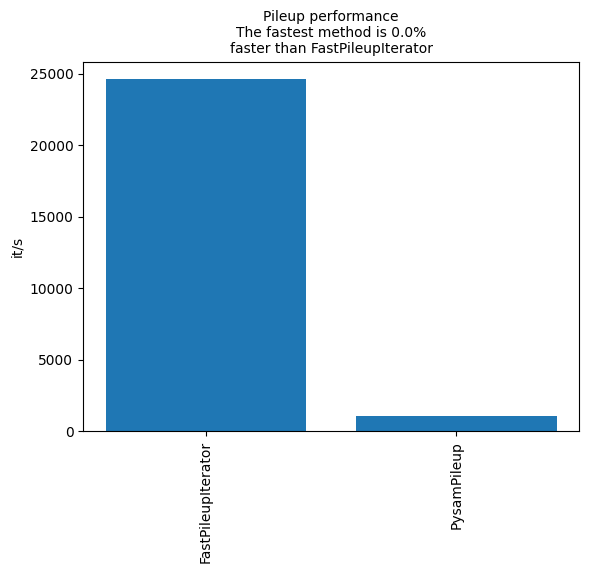

In [43]:
reg=gi('1',22377202,22429853) # the iterated region
times=Counter()
with Timer(times, 'FastPileupIterator') as timer:
    ac1=Counter()
    with open_file_obj(get_resource('small_example_bam')) as bam:
        for l,v in FastPileupIterator(bam, reg.chromosome, range(reg.start, reg.end)):
            ac1[l.chromosome, l.start]=v
with Timer(times, 'PysamPileup') as timer:
    ac2=Counter()
    with open_file_obj(get_resource('small_example_bam')) as bam:
        for pu in bam.pileup(contig=reg.chromosome, start=reg.start-1, stop=reg.end-1, flag_filter=DEFAULT_FLAG_FILTER, 
                             truncate=True,mark_ends=True,add_indels=True,min_base_quality=0,min_mapping_quality=0,
                             ignore_overlaps=False, ignore_orphans=False,
                             max_depth=100000):
            pos=(pu.reference_name, pu.reference_pos+1)
            ac2[pos]=Counter()
            for r in pu.pileups:
                if r.is_refskip:
                    continue
                elif r.is_del:
                    ac2[pos][None]+=1
                else:
                    ac2[pos][r.alignment.query_sequence[r.query_position]]+=1

# PysamPileup will not iterate/report uncovered alignment columns. So, here we add an empty Counters for those positions
for p in (ac1.keys() - ac2.keys()):
    ac2[p]=Counter()
          
# now compare the resulting counters
assert ac1==ac2

# plot the times
plot_times('Pileup performance', times, n=len(reg), our_method='FastPileupIterator')

# show some example columns
head_counter(ac1)

### AnnotationIterator
Annotation iterators are meant to annotate the genomic intervals yielded by one location iterator with data from multiple others. 

In [9]:
# Iterate over annotations in a genomic subregion of the flybase GTF and 
# list the genotypes of annotated SNPs for 3 samples that overlap with those annotations
gff_file=get_resource('flybase_gtf')
vcf_file=get_resource('dmel_multisample_vcf')

with AnnotationIterator(GFF3Iterator(gff_file, '2L', 1, 30000), 
                        VcfIterator(vcf_file, samples=['DGRP-208', 'DGRP-325', 'DGRP-721'])) as it:
    for loc, (v1,v2) in it.take()[:5]:
        display(f"{v1.get('feature_id','NA')},{v1['gene_symbol']}@{loc} {[x.data for x in v2]}", SEP)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.61it/s]


'NA,CR11023@2L:7529-9484 (+) [2L:7556T>C, 2L:7902A>G, 2L:8124A>C, 2L:8263G>A, 2L:9204T>C]'

---

'NA,CR11023@2L:7529-9484 (+) [2L:7556T>C, 2L:7902A>G, 2L:8124A>C, 2L:8263G>A, 2L:9204T>C]'

---

'NA,CR11023@2L:7529-8116 (+) [2L:7556T>C, 2L:7902A>G]'

---

'NA,CR11023@2L:8193-9484 (+) [2L:8263G>A, 2L:9204T>C]'

---

'NA,l(2)gl@2L:9839-11344 (-) [2L:10018G>A, 2L:10089G>A, 2L:10610G>T]'

---

In [6]:
# Annotate all intervals in a BED file with sum of scores from a bedgraph file; supports bedgraph intervals >1bp: 
# score contribution is calculated from the interval overlap (this bedgraph file contains, e.g., an interval (1:7-10, 0.3))
with AnnotationIterator(BedIterator(get_resource('test_bed')), 
                        BedGraphIterator(get_resource('test_bedgraph')), 
                        labels=['scores']) as it:
    for loc, i in it:
        display(f"Annotation {i.anno}, sum:{sum([x.data*loc.overlap(x.location) for x in i.scores])}")
    display(it.stats)

  0%|                                                                                                                                                               | 0/2 [00:00<?, ?it/s]

'Annotation 1:6-10 (int1), sum:1.408'

'Annotation 1:10-15 (int2), sum:0.3'

'Annotation 2:10-150 (int3), sum:0'

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 204.25it/s]


Counter({('iterated_items', '1'): 2, ('iterated_items', '2'): 1})

In [7]:
# Same as above, but now using pybedtools iterators
with AnnotationIterator(PybedtoolsIterator(get_resource('test_bed')), 
                        PybedtoolsIterator(get_resource('test_bedgraph')), labels=['scores']) as it:
    for loc, i in it:
        # Note the slight differences. The returned data is now a pybedtools item, access to the bedgraph score is via the name
        # attribute (but its a string, so we need to convert to float). 
        display(f"Annotation {i.anno}, sum:{sum([float(x.data.name)*loc.overlap(x.location) for x in i.scores])}")
    display(it.stats) # Note that the PybedtoolsIterator also reports the actually yielded items

  0%|                                                                                                                                                               | 0/2 [00:00<?, ?it/s]

'Annotation 1\t5\t10\tint1\n, sum:1.408'

'Annotation 1\t9\t15\tint2\n, sum:0.3'

'Annotation 2\t9\t150\tint3\n, sum:0'

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 23.85it/s]


Counter({('yielded_items', '1'): 2, ('yielded_items', '2'): 1})

## Transcriptome implementation
_Pygenlib_ provides a transcriptome implementation that enables convenient access/filtering of genomic annotations via python. 
Briefly,a (filtered) input GTF/GFF file is parsed and respective (frozen) dataclasses that derive from the generic Feature class are instantiated. 
The implementation keeps track of parent/child relationships (e.g., between genes, transcripts and their exons) and enables efficient iteration/querying and annotation of genomic annotations. Data fields and annotations can conveniently be accessed by `<feature>.<attribute>`. 

Note that the current implementation does not implement the full GFF3 format as specified [here](https://github.com/The-Sequence-Ontology/Specifications/blob/master/gff3.md)
but currently rather supports various popular gff 'flavours' as published by encode, ensembl, ucsc, mirgenedb and flybase.
It also supports a 'generic' GFF3 format where all parsed features are interpreted as 'transcript' objects irrespecting the actual feature_type column.
Respective parent 'gene' annotations are automatically added, no sub-features (exons, introns, etc.) are created.

Here is a brief description of the datamodel depicted below:
-   Model contains genes, transcripts and arbitrary sub-features (e.g., exons, intron, 3'/5'-UTRs, CDS) as defined
    in the GFF file. Note that intron annotations are calculated automatically from exon annotations unless configured otherwise. 
    Frozen dataclasses (derived from the 'Feature' class) are created for all parsed feature
    types automatically and users may configure which GTF/GFF attributes will be parsed and added to those dataclasses as fields.
    
-   A transcriptome maintains an `anno` dict that maps (frozen) features to dicts of arbitrary annotation values which supports the (incremental) annotation of annotation features. Annotation values can be accessed like GFF-parsed fields via 'dot' notation: `<feature>.<attribute>`. 
    
-   The implementation exploits the hierarchical relationship between genes and their sub-features to optimize storage and computational requirements where posssible.        
    Genomic sequences, for example, can be loaded from a reference genome via load_sequences() but will only be directly stored in strings attached to gene feature.
    Sequences can then be accessed via transcriptome.get_sequence(). For sub-features (e.g., transcripts, exons, etc.) the respective sequence will be sliced from the 
    gene sequence on demand.  Note that despite being computed on demand, genomic sequences can still be accessed via `<feature>.sequence` which will call 
    transcriptome.get_sequence() with default parameters.
    
-   The get_sequence() method supports several modes:
    If `mode='rna'` is passed, the sequence is returned in 5'-3' orientation, i.e., they are reverse-complemented
    for minus-strand transcripts. The returned sequence will, however, still use the DNA alphabet (ACTG) to
    enable direct alignment/comparison with genomic sequences.
    if `mode='spliced'`, the spliced 5'-3' sequence will be returned.
    if `mode='translated'`, the spliced 5'-3' CDS sequence will be returned.
    
-   Genomic range queries via query() are supported by a combination of interval and linear search queries.
    A transcriptome object maintains one intervaltree per chromosome built from gene annotations.
    Overlap/envelop queries will first be applied to the respective intervaltree and the (typically small
    result sets) will then be filtered, e.g., for requested sub-feature types.
    
-   Transcriptome models can also be built from subsets of GFF/GTF files by filtering contained transcripts with a TranscriptFilter() that can restrict included chromosomes, genomic regions, transcript_ids, gene_types or transcripts with certain 'tag' values (as used in gencode).

-   The transcriptome build process is configured by a single JSON file/dict as shown below. The transcriptome object keeps track of the numbers of filtered GFF entries in a `log` Counter object that is, e.g., useful for debugging. The 'structure' of the parsed features can be accessed via the `get_struct()` method.

The following cells demonstrate some use cases.

----

![transcriptome datamodel](pygenlib_transcriptome.png "Transcriptome datamodel")

### Basic access examples

In [12]:
# First, let's create a transcriptome containing dmel chromosome 2L annotation from a flybase annotation file.
config = {
        'genome_fa': get_resource('dmel_genome'),      # genome FASTA
        'annotation_gff': get_resource('flybase_gtf'), # Gene annotation GTF/GFF file
        'annotation_flavour': 'flybase',               # flavour of the annotation file.
        'transcript_filter': {                         # a simple filter that will include only annotations from 2L
            'included_chrom': ['2L']
        },
        'load_sequences': True # load sequences from configured genome FASTA file
    }
t = Transcriptome(config)
# show some stats/debugging information
display(t)
display(t.get_struct())
display(t.log)

Building transcriptome (Filtered (0 tags, 0 tids, 0 genetypes, 1 chroms, 0 regions).): 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.14it/s]
Build interval tree: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12249.72it/s]


Transcriptome with 5 genes and 22 tx (+seq)

Counter({'transcript': {'CDS',
          'exon',
          'five_prime_UTR',
          'gene',
          'intron',
          'three_prime_UTR',
          'transcript'},
         'gene': {'transcript'},
         'exon': set(),
         'intron': set(),
         'three_prime_UTR': set(),
         'CDS': set(),
         'five_prime_UTR': set()})

Counter({'parsed_gff_lines': 411})

In [13]:
# Now, lets access some data:                                                                          
display(f"Transcript types: {Counter([tx.feature_type for tx in t.transcripts])}") # count all transcript_type fields that were parsed from the flybase feature_types
display(f"Transcripts of gene 'l(2)gl': {[tx.feature_id for tx in t.gene['l(2)gl'].transcript]}.") # query gene by name and get its transcripts
display(f"Number of exons per l(2)gl tx: { {tx.feature_id:len(tx.exon) for tx in t.gene['l(2)gl'].transcript} }") # get number of exons for all l(2)gl transcripts
display(f"So, the gene of transcript 'FBtr0330655' is {t.transcript['FBtr0330655'].parent.gene_name}") # Access transcript by id and show the name field of its gene (=parent)

"Transcript types: Counter({'transcript': 22})"

"Transcripts of gene 'l(2)gl': ['FBtr0306591', 'FBtr0078169', 'FBtr0078168', 'FBtr0078170', 'FBtr0306592', 'FBtr0306590', 'FBtr0078167', 'FBtr0330655', 'FBtr0078171', 'FBtr0078166', 'FBtr0306589']."

"Number of exons per l(2)gl tx: {'FBtr0306591': 10, 'FBtr0078169': 10, 'FBtr0078168': 9, 'FBtr0078170': 9, 'FBtr0306592': 11, 'FBtr0306590': 9, 'FBtr0078167': 9, 'FBtr0330655': 9, 'FBtr0078171': 10, 'FBtr0078166': 9, 'FBtr0306589': 10}"

"So, the gene of transcript 'FBtr0330655' is l(2)gl"

In [14]:
# Some more access examples
# genes can be accessed by name or gene id; their location
display(f"The gene {t.gene['l(2)gl'].gene_name} is located on chromosome {t.gene['l(2)gl'].location.chromosome} at {t.gene['FBgn0002121'].location} ", SEP) 

# you can inspect the fields of a transcriptome feature with regular python methods, e.g. vars()
# Here we show, e.g., the structure of the 1st transcript
tx=t.gene['l(2)gl'].transcript[0]
display_textarea(pprint.pformat(vars(tx)))

# fields as well as dynamic annotations (see below) can be accessed by <feature>.<attribute/field> notation
# this includes calculated annotations such as location and rnk (exon/intron number)
display(f"transcript_id: {tx.feature_id}, location: {tx.location}, 1st exon rnk: {tx.exon[0].rnk}")


'The gene l(2)gl is located on chromosome 2L at 2L:9839-21376 (-) '

---

'transcript_id: FBtr0306591, location: 2L:9839-21376 (-), 1st exon rnk: 1'

### Sequence access

In [15]:
# Genomic sequences are another example for dynamically calculated annotations. 
# They must first be loaded for each gene annotation with load_sequences() 
# which is done automatically if 'load_sequences': True is configured.
# They can be accessed by the t.get_sequence() method or by <feature>.sequence which calls 
# get_sequence() with default params.
# W demonstrate this by accessing some data of a transcript of the 'l(2)gl-RJ (FBgn0002121)' gene

display_textarea(f"Sequence of 1st FBtr0330655 exon: {t.transcript['FBtr0330655'].exon[0].sequence}")
display_textarea(f"Spliced sequence of FBtr0330655: {t.transcript['FBtr0330655'].spliced_sequence}")

# SJs can be displayed by calling get_sequence(mode='spliced', show_exon_boundaries=True)
display_textarea(f"Spliced sequence of FBtr0330655 showing SJ ('*'): {t.get_sequence(t.transcript['FBtr0330655'] ,mode='spliced', show_exon_boundaries=True)}")

# sequences will be reverse complemented for - strand transcripts if mode='rna'
# get random minustrand tx
tx=random.sample([tx for tx in t.transcripts if tx.strand=='-'], 1)[0]

# show sequence of 1st exon in dna and rna mode
display(f"tx {tx.feature_id}, exon 1: dnaseq={t.get_sequence(tx.exon[0], mode='dna')}, rnaseq={t.get_sequence(tx.exon[0], mode='rna')}", SEP)

'tx FBtr0309226, exon 1: dnaseq=GGAGGATGAGTTCCGCGGTTGGGCGTGGATATCACGTCTCGATCCTGATTACTGTACATGGCACTGCCCCGGTTCCTGTTGTTGTTT, rnaseq=AAACAACAACAGGAACCGGGGCAGTGCCATGTACAGTAATCAGGATCGAGACGTGATATCCACGCCCAACCGCGGAACTCATCCTCC'

---

In [16]:
# The transcriptome implementation also supports (annotated) CDS annotations. Users can directly access the translated sequence:
display_textarea(f"Translated sequence of FBtr0330655: {t.transcript['FBtr0330655'].translated_sequence}")

# align spliced and translated sequence
display_textarea(f"Alignment scores: {align_sequence(t.transcript['FBtr0330655'].translated_sequence, t.transcript['FBtr0330655'].spliced_sequence, report_alignment=True)}")

# translate with biopythons
display_textarea(f"Amino acid sequence of FBtr0078164: {Seq(t.transcript['FBtr0330655'].translated_sequence).translate()}")

Exact kmer search in sequences can be performed by standard python methods

In [17]:
# list all gene names where the kmer is found in one of the (spliced) transcripts
display(f"Genes containing kmer in one of their (spliced) tx: { { tx.parent.gene_name for tx in t.transcripts if 'ATGC' in tx.spliced_sequence }}", SEP)

# list all gene names where the kmer is found in one of its transcripts introns considering only long (>1kb) introns
display(f"Genes containing kmer in a long (>1kb) intron: { { tx.parent.gene_name for tx in t.transcripts for intron in tx.intron if len(intron)>1000 and 'ATGC' in intron.sequence}}", SEP)

"Genes containing kmer in one of their (spliced) tx: {'l(2)gl', 'Cda5', 'Ir21a', 'CR11023', 'asRNA:CR43609'}"

---

"Genes containing kmer in a long (>1kb) intron: {'l(2)gl'}"

---

### Range queries

In [18]:
# Efficient range queries are implemented by intervaltrees:
display(f"Genes where an exon overlaps with 2L:10000-20000: { {ex.parent.parent.gene_name for ex in t.query(gi.from_str('2L:10000-20000'), 'exon')}}", SEP) 

# Query all transcripts that overlap with the 'l(2)gl' gene and create a set with their gene names.
l2gl=t.gene['l(2)gl'] # note that each transcriptome feature is also a genomic interval and can be queried
display(f"Genes of all transcripts that overlap with gene 'l(2)gl': {set(tx.parent.gene_name for tx in t.query(l2gl, 'transcript'))}", SEP) 

# report a coordinate-sorted list of genes in a 10kb window around cold:
display(f"Genes near 'l(2)gl': { [g.gene_name for g in t.query(gi(l2gl.chromosome, l2gl.start-3000, l2gl.end+3000), 'gene')]}", SEP)

# envelop queries are also supported:
display(f"Genes contained in a +/- 10kb window around 'l(2)gl': { [g.gene_name for g in t.query(gi(l2gl.chromosome, l2gl.start-3000, l2gl.end+3000), 'gene', envelop=True)]}")

"Genes where an exon overlaps with 2L:10000-20000: {'l(2)gl'}"

---

"Genes of all transcripts that overlap with gene 'l(2)gl': {'l(2)gl'}"

---

"Genes near 'l(2)gl': ['CR11023', 'l(2)gl', 'Ir21a', 'asRNA:CR43609']"

---

"Genes contained in a +/- 10kb window around 'l(2)gl': ['CR11023', 'l(2)gl', 'asRNA:CR43609']"

### Advanced Examples

In [19]:
# iterate genes and their up/downstream genes within a given max distance. Show only first 10 entries.
# gene_triples is a convenience method that yields genes and their neighbouring (up-/downstream) genes
def get_name(x):
    return None if x is None else x.gene_name
[(get_name(x),get_name(y),get_name(z)) for x, y, z in t.gene_triples(max_dist=10000)][:10] # Note that, e.g., for lncRNA:CR46254, there is no downstream gene within 10kb

[(None, 'CR11023', 'l(2)gl'),
 ('CR11023', 'l(2)gl', 'Ir21a'),
 ('l(2)gl', 'Ir21a', 'asRNA:CR43609'),
 ('Ir21a', 'asRNA:CR43609', 'Cda5'),
 ('asRNA:CR43609', 'Cda5', None)]

In [20]:
# Create a dict of genes and their unique 1000bp 3'UTR intervals per tx (multiple intervals if spliced); 
# note that for Ir21a/FBtr0113008 2 intervals are reported as the 1000bp UTR overlaps a splice junction
{g.gene_name: {tx.feature_id:calc_3end(tx, width=1000) for tx in g.transcript} for g in t.genes}

{'CR11023': {'FBtr0475186': [2L:8485-9484 (+)]},
 'l(2)gl': {'FBtr0306591': [2L:9839-10838 (-)],
  'FBtr0078169': [2L:9839-10838 (-)],
  'FBtr0078168': [2L:9839-10838 (-)],
  'FBtr0078170': [2L:9839-10838 (-)],
  'FBtr0306592': [2L:9839-10838 (-)],
  'FBtr0306590': [2L:9839-10838 (-)],
  'FBtr0078167': [2L:9839-10838 (-)],
  'FBtr0330655': [2L:9839-10838 (-)],
  'FBtr0078171': [2L:9839-10838 (-)],
  'FBtr0078166': [2L:9839-10838 (-)],
  'FBtr0306589': [2L:9839-10838 (-)]},
 'Ir21a': {'FBtr0113008': [2L:21823-22687 (-), 2L:22743-22877 (-)]},
 'asRNA:CR43609': {'FBtr0309810': [2L:23238-24237 (+)]},
 'Cda5': {'FBtr0309227': [2L:25402-26401 (-)],
  'FBtr0309228': [2L:25402-26401 (-)],
  'FBtr0309226': [2L:25402-26401 (-)],
  'FBtr0309229': [2L:25402-26401 (-)],
  'FBtr0078163': [2L:25402-26401 (-)],
  'FBtr0078164': [2L:25402-26401 (-)],
  'FBtr0113416': [2L:25402-26401 (-)],
  'FBtr0309225': [2L:25402-26401 (-)]}}

In [21]:
# complex query examples
# find all minus strand genes with transcripts that have >=2 exons and at least one long (>1kb) intron
{tx.parent.gene_name for tx in t.transcripts if tx.strand=='-' and len(tx.exon)>=2 and any([len(i)>1000 for i in tx.intron])}

{'l(2)gl'}

#### Example: get downstream windows
Here we iterate all transcripts and calculate a downstream (3') genomic window and its dna sequence. 
(NB: For adding 5'-end windows, just use 'upstream' as window_type)

In [22]:
window_type='downstream'
ws=3
genome_offsets = get_config(t.config, 'genome_offsets', default_value={}) # get genome offsets from config (if any)
# NOTE that you can also load sliced genome sequences and correct coordinates using the 'genome_offsets' config key
# see below for an example
with pysam.Fastafile(get_config(t.config, 'genome_fa', required=True)) as fasta:
    for tx in tqdm(t.transcripts, desc=f'Load {window_type} window sequences', total=len(t.transcripts)):
        strand = tx.strand
        assert strand is not None, f"Undefined strand for tx {tx}"
        loc = tx.get_upstream(ws) if window_type == 'upstream' else tx.get_downstream(ws)  # get up/downstream windows of given size
        dna_seq=''
        s = loc.start - genome_offsets.get(loc.chromosome, 1) 
        if s<0: # Pad with N's if required
            dna_seq='N'*(-s)
            s=0
        e = loc.end - genome_offsets.get(loc.chromosome, 1) + 1
        dna_seq+=fasta.fetch(reference=loc.chromosome,start=s,end=e) # get sequence from FASTA
        display(f"{window_type}: {tx.parent.gene_name},{tx.feature_id}, {loc}, {dna_seq}")

Load downstream window sequences:   0%|                                                                                                                            | 0/22 [00:00<?, ?it/s]

'downstream: CR11023,FBtr0475186, 2L:9485-9487 (+), AAA'

'downstream: l(2)gl,FBtr0078170, 2L:9836-9838 (-), TTT'

'downstream: l(2)gl,FBtr0078171, 2L:9836-9838 (-), TTT'

'downstream: l(2)gl,FBtr0306591, 2L:9836-9838 (-), TTT'

'downstream: l(2)gl,FBtr0078169, 2L:9836-9838 (-), TTT'

'downstream: l(2)gl,FBtr0078168, 2L:9836-9838 (-), TTT'

'downstream: l(2)gl,FBtr0306592, 2L:9836-9838 (-), TTT'

'downstream: l(2)gl,FBtr0306590, 2L:9836-9838 (-), TTT'

'downstream: l(2)gl,FBtr0078167, 2L:9836-9838 (-), TTT'

'downstream: l(2)gl,FBtr0330655, 2L:9836-9838 (-), TTT'

'downstream: l(2)gl,FBtr0078166, 2L:9836-9838 (-), TTT'

'downstream: l(2)gl,FBtr0306589, 2L:9836-9838 (-), TTT'

'downstream: Ir21a,FBtr0113008, 2L:21820-21822 (-), TGT'

'downstream: asRNA:CR43609,FBtr0309810, 2L:24238-24240 (+), ACC'

'downstream: Cda5,FBtr0309227, 2L:25399-25401 (-), ATT'

'downstream: Cda5,FBtr0309228, 2L:25399-25401 (-), ATT'

'downstream: Cda5,FBtr0309229, 2L:25399-25401 (-), ATT'

'downstream: Cda5,FBtr0078163, 2L:25399-25401 (-), ATT'

'downstream: Cda5,FBtr0078164, 2L:25399-25401 (-), ATT'

'downstream: Cda5,FBtr0113416, 2L:25399-25401 (-), ATT'

'downstream: Cda5,FBtr0309225, 2L:25399-25401 (-), ATT'

'downstream: Cda5,FBtr0309226, 2L:25399-25401 (-), ATT'

Load downstream window sequences: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 547.49it/s]


### Annotation of features

A transcriptome manages an `anno` dict that maps annotation features (e.g., an exon) to a dict containing arbitray annotations.
Annotations can be added manually or by using the `transcriptome.annotate()` method that implements a generic method to add feature-based annotations.
The following section demonstrates some use cases:

In [23]:
# First, let's instantiate a small transcriptome that contains only two human genes (ACTB and SOX2) 
config = {
        'genome_fa': get_resource('ACTB+SOX2_genome'),  # get_resource('ACTB+SOX2_genome'),
        # this is a sliced reference sequence. To match the gencode annotations we provide respective offset coordinates for the 2 chroms
        'genome_offsets': {'chr3': 181711825, 'chr7': 5526309}, 
        'annotation_gff': get_resource('gencode_gff'),  # get_resource('gencode_gff'),,
        'annotation_flavour': 'gencode',
        '#transcript_filter': {
            'included_genetypes': ['protein_coding']
        },
        'load_sequences': True
    }

t=Transcriptome(config)

Build interval tree: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 15923.71it/s]


In [24]:
# Now, lets annotate exons and introns with mappability scores that are read from a bedgraph file.
# We first create a method for calculating the mean mappability for an annotation based on the scores of
# all overlapping intervals from the bedgraph file.
def calc_mean(item, label='mappability'):
    loc, (anno, scores) = item
    anno[label]=sum([score*loc.overlap(sloc) for sloc,score in scores])/len(loc)
    return calc_mean

# now we can call the annotate method, tell it to get the scores from a bedgraph iterator and
# to annotate only exons + introns. Note that this test bedgraph file covers only ~half of ACTB,
# (use a genome  browser like IGV to confirm this). So the mappability of the uncovered regions will 
# be set to zero.
t.annotate(iterators=BedGraphIterator(get_resource('human_umap_k24')),
           fun_anno=calc_mean,
           feature_types=['exon', 'intron'])

# Now, lets show the mappability values for exons and introns of one random transcript 
rnd_tx = random.sample(t.gene['ACTB'].transcript, 1)[0]
display([(f.rnk, f.feature_id, f.mappability) for f in rnd_tx.exon])

# Note that it would be more efficient to annotate genes with mappability score arrays and then calculate mean/median mappability
# for each feature by slicing these arrays (as done, e.g., for sequences) but this is omited here for the sake of simplicity

0it [00:00, ?it/s]
buf=[0]: : 86it [00:00, 849.34it/s]                                                                                                                                 | 0/2 [00:00<?, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.06it/s]
buf=[0]: : 190it [00:00, 931.51it/s]


[(1, 'ENST00000646664.1_exon_5', 0.974448717948718),
 (2, 'ENST00000646664.1_exon_4', 0.8161705426356585),
 (3, 'ENST00000646664.1_exon_3', 0.28020416666666664),
 (4, 'ENST00000646664.1_exon_2', 0.0),
 (5, 'ENST00000646664.1_exon_1', 0.0),
 (6, 'ENST00000646664.1_exon_0', 0.0)]

In [25]:
# If unsure whether a feature has a respective annotation, you can access it via the python getattr() method and
# provide a default value in case it does not exist.
display_textarea(f"Sequence of ACTB: {getattr(t.gene['ACTB'],'sequence',None)}")
display(f"gene has no mappability value: {getattr(t.gene['ACTB'],'mappability',None)}")
display(f"exon has mappability value: {getattr(t.transcript['ENST00000477812.2'].exon[0],'mappability',None)}")

'gene has no mappability value: None'

'exon has mappability value: 0.9702537313432836'

#### Example: Calculate number of overlapping features
In this example, we calculate the number of overlapping introns per exon.

0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 23.72it/s]
buf=[0]: : 108it [00:00, 1200.96it/s]


"Example exon@chr7:5529067-5529663 with 33 overlapping introns: {'ENST00000676397.1_intron_3', 'ENST00000417101.2_intron_0', 'ENST00000473257.3_intron_2', 'ENST00000642480.2_intron_3', 'ENST00000674681.1_intron_3', 'ENST00000473257.3_intron_3', 'ENST00000646664.1_intron_3', 'ENST00000462494.5_intron_2', 'ENST00000443528.5_intron_0', 'ENST00000676189.1_intron_2', 'ENST00000432588.6_intron_1', 'ENST00000484841.6_intron_1', 'ENST00000432588.6_intron_2', 'ENST00000676397.1_intron_2', 'ENST00000647275.1_intron_1', 'ENST00000674681.1_intron_2', 'ENST00000425660.5_intron_4', 'ENST00000645576.1_intron_2', 'ENST00000477812.2_intron_2', 'ENST00000645025.1_intron_0', 'ENST00000645025.1_intron_1', 'ENST00000642480.2_intron_2', 'ENST00000493945.6_intron_3', 'ENST00000646664.1_intron_2', 'ENST00000675515.1_intron_3', 'ENST00000493945.6_intron_2', 'ENST00000414620.1_intron_0', 'ENST00000425660.5_intron_3', 'ENST00000484841.6_intron_2', 'ENST00000676319.1_intron_0', 'ENST00000645576.1_intron_1', 'ENST

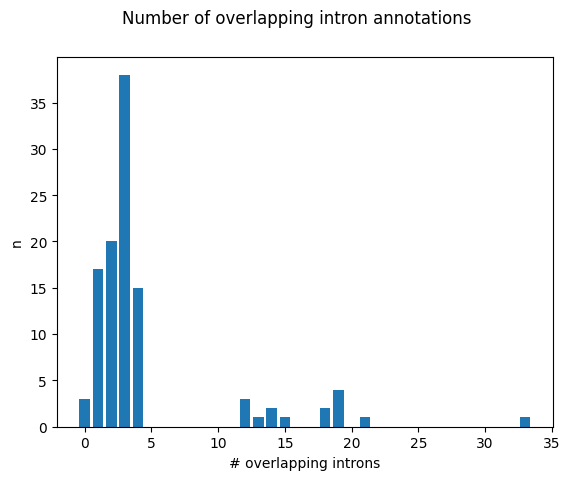

In [26]:
# Here we calculate the number of overlapping introns per exon.
def count_anno(item):
    loc, (anno, overlapping) = item
    # Here we simply count the number of overlapping intron annotations but we could also group
    # by tx or gene, etc.
    anno['n_overlapping_introns']=len(overlapping)
    anno['overlapping_introns']=overlapping

# now we can call the annotate method for all exons of this transcriptome and tell it to 
# annotate with all introns of this transcriptome. In the passed annotation method (count_anno) we 
# simply count the number of overlapping annotations (introns).
# Its easy to check in IGV (loading the GFF3 file) whether the numbers are correct.
t.clear_annotations()
t.annotate(iterators=TranscriptomeIterator(t,feature_types=['intron']),
           fun_anno=count_anno,
           feature_types=['exon'])

# Here we create a histogram ...
intron_hist=Counter()
for ex in TranscriptomeIterator(t,feature_types=['exon']):
    intron_hist[ex.data['n_overlapping_introns']]+=1

# ... and plot it
x, y = zip(*intron_hist.items())
_=plt.bar(x,y)
plt.xlabel("# overlapping introns")
plt.ylabel("n")
_=plt.suptitle("Number of overlapping intron annotations")

# Here we show one example with max number of overlapping introns
# NOTE that there can be multiple introns per transcript that overlap with a given exon.
for ex,info in TranscriptomeIterator(t,feature_types=['exon']):
    if info.get('n_overlapping_introns', 0)==max(intron_hist):
        tids = {i.parent.feature_id for i,_ in info['overlapping_introns']}
        display(f"Example {ex} with {info['n_overlapping_introns']} overlapping introns: { {i.feature_id for i,_ in info['overlapping_introns']} }, tids: {tids}")
        break    

# Related Work

Recently, a number of different python libraries for the efficient manipulation/querying of genomic interval sets were developed.
This includes [pybedtools](https://daler.github.io/pybedtools/index.html), a python library wrapping the popular BEDTools utilities, and 
[bioframe](https://bioframe.readthedocs.io/en/latest/index.html), a python library enabling flexible and scalable operations on genomic intervals built on top of pandas dataframes. 

These as well as related libraries (e.g., [pyranges](https://pyranges.readthedocs.io/en/latest/index.html) or [pygenomics](https://gitlab.com/gtamazian/pygenomics))
enable efficent set operations (e.g., intersect, merge, count, complement) on genomic intervals but differ in various aspects of design and implementation. In this regard, their functionality overlaps partially with pygenlib's genomic iterators that are mainly built on the [pysam](https://pysam.readthedocs.io/en/latest/) implementation.

While using these libraries on large datasets is often considerably faster than the corresponding 'native' pygenlib iterators, it is also a bit 'unsafer' to use them as [demonstrated below](#) as ...

After highlighting such potential pitfalls, we show some [performance comparisons](#Performance-comparison) for various scenarios and show that speed benefits are often anulled when considering only subsets of large datasets (such as features of certain types on certain chromosomes) as the compared libraries either load the whole dataset before filtering can be applied (e.g., bioframe) or need to apply relatively costly preprocessing operations (such as pybedtools intersect) that are efficiently solved by pygenlib's pysam-based iterators that leverage the respective indexing structures for this purpose.

Overall, however, we envision that user's would like to mix and match these APIs for maximum overall benefit. Users could, for example, first use pybedtools or bioframe operations on some input file and then run custom pygenlib transcriptomics analyses on them. We showcase a realistic scenario for [such a cooperation](#Combined-Bioframe-and-Pygenlib-example) below.



## Performance comparison
Here we compare iteration speed for various iterators in different scenarios and plot the results.
Note that many factors are influencing these benchmarks (such as I/O speed, memory consumption, file composition, etc.) so be careful about the drawn conclusions.

### Calculate average feature lengths
In this exampl, we compare different ways to calculate the average feature length in a medium-sized bed file (from the pybedtools testdata repository).
- pygenlib's PybedtoolsIterator is slowest due to additional overhead of converting bedtools data to pygenlib representations
- pygenlib's BedIterator is a lot faster but still slower than the pybedtools approach
- The pybedtools approach is slighly faster as it relies on the performant bedtools implementation
- the bioframe approach is fastest for this task as it first loads the whole dataset into a pandas dataframe that then allows very efficient calculation of mean feature lengths

In [5]:
ssl._create_default_https_context = ssl._create_unverified_context # to avoid invalid certificate problems
BioframeIterator('https://www.encodeproject.org/files/ENCFF401MQL/@@download/ENCFF401MQL.bed.gz', schema='narrowPeak').df

,chrom,start,end,name,score,strand,fc,-log10p,-log10q,relSummit
0,chr19,48309541,48309911,.,1000,.,5.04924,-1.0,0.00438,185
1,chr4,130563716,130564086,.,993,.,5.05052,-1.0,0.00432,185
2,chr1,200622507,200622877,.,591,.,5.05489,-1.0,0.00400,185
3,chr5,112848447,112848817,.,869,.,5.05841,-1.0,0.00441,185
4,chr1,145960616,145960986,.,575,.,5.05955,-1.0,0.00439,185
...,...,...,...,...,...,...,...,...,...,...
40582,chr8,22574315,22574744,.,1000,.,561.11939,-1.0,4.90268,243
40583,chr15,56246029,56246402,.,1000,.,569.05663,-1.0,4.90268,191
40584,chr1,150979463,150979845,.,1000,.,580.28482,-1.0,4.90268,194
40585,chr16,57649040,57649402,.,1000,.,602.95266,-1.0,4.90268,173


DF filter string: start>=(@self.region.start+@coord_off[0])&end<=(@self.region.end+@coord_off[1]), region: None:-inf-inf


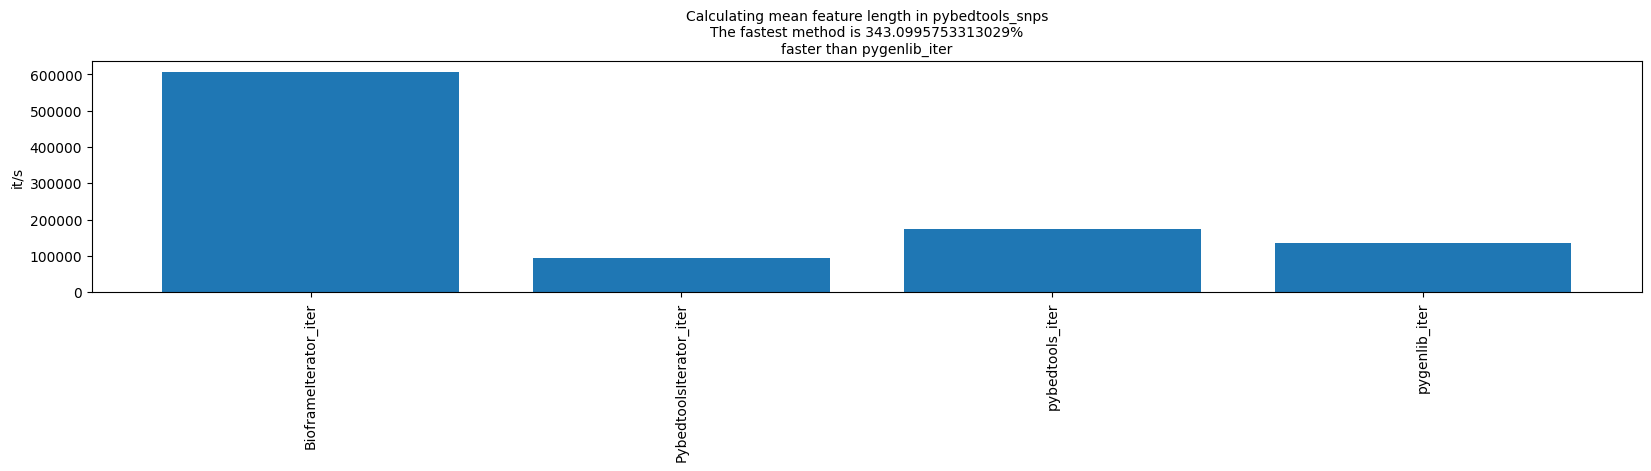

In [38]:
dataset='pybedtools_snps'
bed_file = get_resource(dataset)
times, data=Counter(),Counter()
with Timer(times, 'pygenlib_iter') as timer:
    data[timer.name] = []
    with BedIterator(bed_file) as it:
        data[timer.name]=np.mean([len(loc) for loc,_ in it])
        stats=it.stats
with Timer(times, 'pybedtools_iter') as timer:
    data[timer.name] = np.mean([x.end-x.start for x in pybedtools.BedTool(bed_file)])
with Timer(times, 'PybedtoolsIterator_iter') as timer:
    with PybedtoolsIterator(pybedtools.BedTool(bed_file)) as it:
        data[timer.name]=np.mean([len(loc) for loc,_ in it])
with Timer(times, 'BioframeIterator_iter') as timer:
    with BioframeIterator(bed_file) as it:
        it.df['len']=it.df['end']-it.df['start']
        data[timer.name] = it.df['len'].mean()

    
# assert that results match
assert len({y for y in data.values()})==1, f"Error in some computation: {data}"

plot_times(f"Calculating mean feature length in {dataset}",
           times, n=stats[('yielded_items', None)],
           our_method='pygenlib_iter')

### Random intervals
Here we test grouped aggregation of some property using random datasets. First, we create a data frame with random intervals and random values between [0; 1000] and store it as bgzipped+tabixed bedgraph file. Then we test different methods for calculating the mean score a grouped mean score. 

- For pybedtools, we intersect the file per chromosome, store the values in a numpy array and calculate the mean
- For bioframe, we use the pygenlib BioframeIterator class to load the dataframe and group/aggregate with pandas functionality
- We use pygenlib's BedGraphIterator to iterate the values per chromosome, store them in a numpy array and calculate the mean

Bioframe is the fastest option for this task due to the effienct pandas data grouping/aggregation functionality. Pygenlib's BedGraphIterator iterator comes out second as per-chromosome grouping is more efficiently handled than in pybedtools.

Detected file format for index creation: bed


'Evaluating dataset with size n=1000.0'

DF filter string: start>=(@self.region.start+@coord_off[0])&end<=(@self.region.end+@coord_off[1]), region: None:-inf-inf
Detected file format for index creation: bed


'Evaluating dataset with size n=10000.0'

DF filter string: start>=(@self.region.start+@coord_off[0])&end<=(@self.region.end+@coord_off[1]), region: None:-inf-inf
Detected file format for index creation: bed


'Evaluating dataset with size n=100000.0'

DF filter string: start>=(@self.region.start+@coord_off[0])&end<=(@self.region.end+@coord_off[1]), region: None:-inf-inf


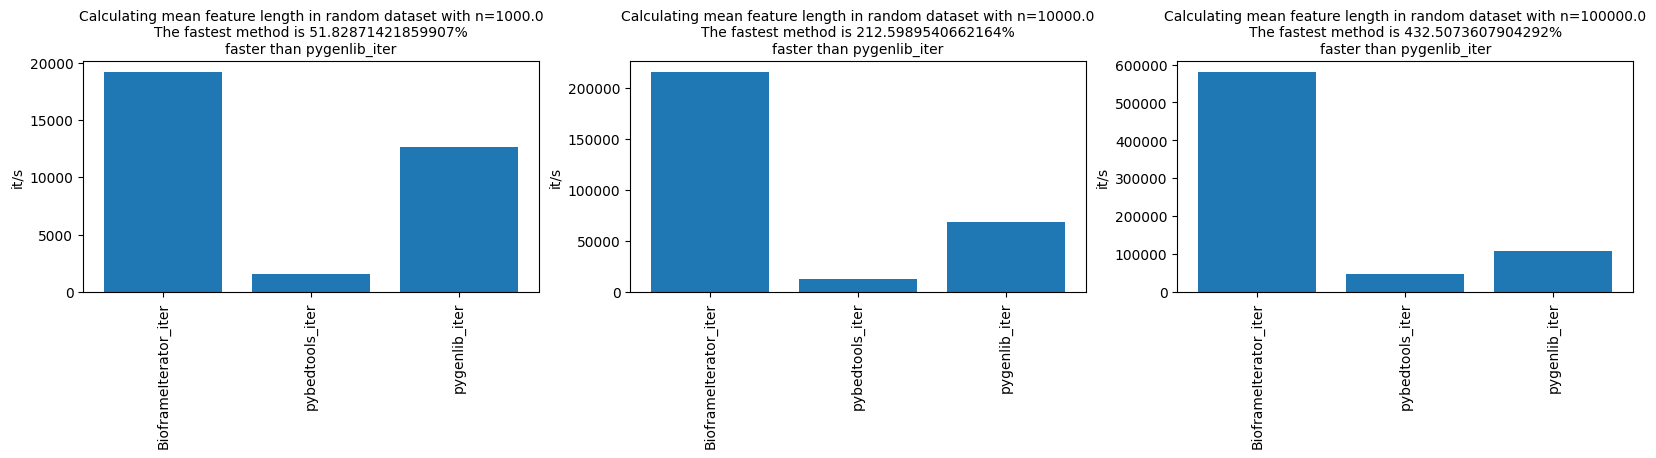

In [39]:
# from pygenlib.testdata import make_random_intervals
sizes=[1e3,1e4,1e5]#,1e6]
chroms=['chr' + str(i + 1) for i in range(20)]
fig, axes = plt.subplots(ncols=len(sizes), squeeze=True)
stats=Counter()
for n,ax in zip(sizes,axes):
    with tempfile.TemporaryDirectory() as tempdirname:
        dataset='random dataset'
        bed_file=f'{tempdirname}/data.bedgraph'
        # create testdata
        make_random_intervals(n=n, chroms=chroms).to_csv(bed_file, sep='\t', encoding='utf-8', index=False, header=False)
        bgzip_and_tabix(bed_file)
        bed_file+='.gz'
        display(f"Evaluating dataset with size n={n}")
        times, data, stats=Counter(),Counter(),Counter()        
        with Timer(times, 'pygenlib_iter') as timer:
            data[timer.name] = {}
            for chrom in chroms:
                with BedGraphIterator(bed_file, chromosome=chrom) as it:
                    data[timer.name][chrom]=np.mean([v for loc,v in it])
                    stats.update(it.stats)
        with Timer(times, 'pybedtools_iter') as timer:
            data[timer.name] = {}
            for chrom in chroms:
                data[timer.name][chrom] = np.mean([float(x.name) for x in pybedtools.BedTool(bed_file).intersect([gi(chrom).to_pybedtools()], u=True)])
        with Timer(times, 'BioframeIterator_iter') as timer:
            with BioframeIterator(bed_file) as it:
                data[timer.name] = it.df.groupby('chrom')['name'].mean().to_dict()
        # assert that results match
        for c in chroms:
            assert check_list([data['pygenlib_iter'][c], data['pybedtools_iter'][c], data['BioframeIterator_iter'][c]], 'eq'),\
                f"Error on chrom {c}: {data['pygenlib_iter'][c], data['pybedtools_iter'][c], data['BioframeIterator_iter'][c]}"
        # plot the results
        plot_times(f"Calculating mean feature length in {dataset} with n={n}",
                   times, n=np.sum([stats['yielded_items',c] for c in chroms]),
                   our_method='pygenlib_iter',
                   ax=ax)
plt.rcParams["figure.figsize"] = (20,3)
plt.show()

### Filtered iteration
Here we add some more filtering steps and compare different methods for counting minus strand features on one chromosome in a large GFF3 file that is downloaded from gencode to a temporary directory, sorted, bgzipped, index and then analysed.

- for pybedtools, we either intersect the file or apply a filter method, then parse the respective fields and count
- for bioframe, we init a filtered DataFrame via our BioframeIterator implementation, filter for the proper strand using pandas and then iterate+count
- we use a chromosome-filtered pygenlib GFF3Iterator for comparison, filter by interval strand and count the returned feature_type 

The pybedtools_filter option is slowest as it needs to iterate the whole dataset when filtering.
The pybedtools_intersect option is much faster but also dominated by the intersect (chrom filtering) operation.
The shown pandas/bioframe approach is also relatively slow as it also needs to read the whole dataframe before filtering in two steps for the targeted genomic region and strand. 
Finally, the pygenlib GFF3Iterator (based on pysam) is the fastest option in this benchmark, probably due to the fast chromosome filtering based on the leveraged tabix index.


DF filter string: chrom==@self.region.chromosome&start>=(@self.region.start+@coord_off[0])&end<=(@self.region.end+@coord_off[1]), region: chr21:-inf-inf


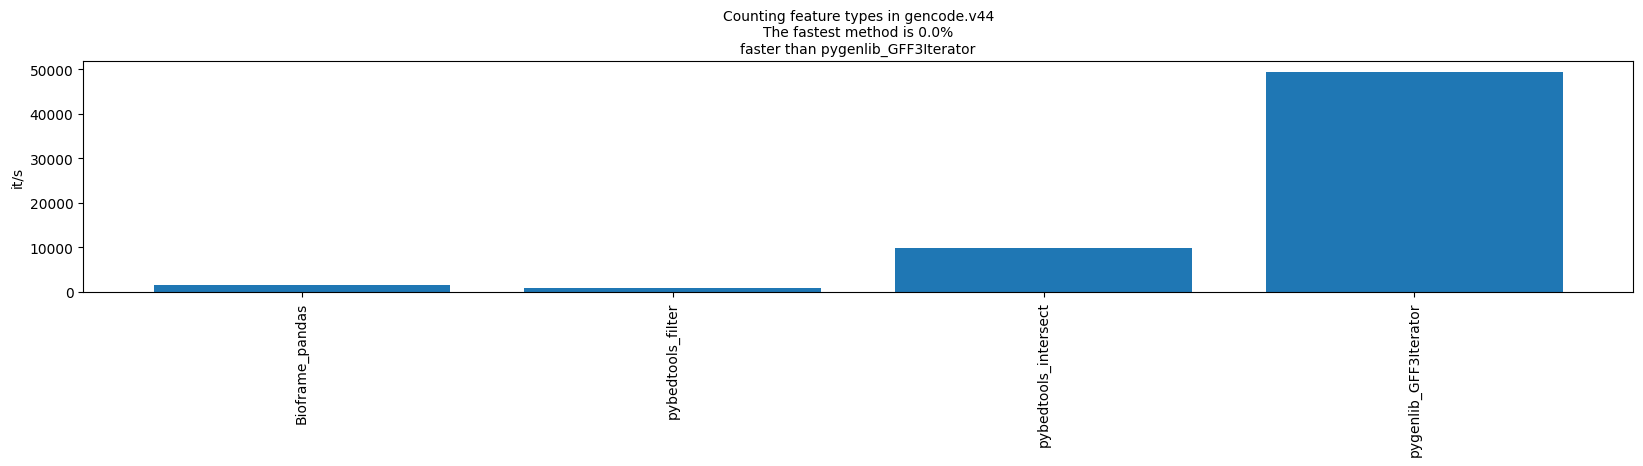

In [40]:
import subprocess
dataset='gencode.v44'
with tempfile.TemporaryDirectory() as tempdirname:
    # download, sort, bgzip and index gencode v44 annotation GFF3 file
    gff_file=f"{tempdirname}/gencode.v44.annotation.gff3.gz"
    tmpfile = download_file("https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_44/gencode.v44.annotation.gff3.gz", 
                                       f"{tempdirname}/unsorted.gff3.gz")
    subprocess.call(f'bedtools sort -header -i {tmpfile} | bgzip > {gff_file}', shell=True)  # index
    subprocess.call(f'tabix {gff_file}', shell=True)  # index

    roi=gi('chr21') # count on one chromosome only
    times, data=Counter(),Counter()
    with Timer(times, 'pybedtools_filter') as timer:
        data[timer.name]=Counter()
        for x in pybedtools.BedTool(gff_file).filter(lambda b: b.chrom == roi.chromosome and b.strand=='-'):
            feature_type = x.fields[2]
            data[timer.name][feature_type]+=1
            data[timer.name]['-']+=1
    with Timer(times, 'pybedtools_intersect') as timer:
        data[timer.name]=Counter()
        for x in pybedtools.BedTool(gff_file).intersect([roi.to_pybedtools()], u=True):
            strand, feature_type = x.strand, x.fields[2]
            if strand == '-':
                data[timer.name][feature_type]+=1
                data[timer.name][strand]+=1
    with Timer(times, 'pygenlib_GFF3Iterator') as timer:
        data[timer.name]=Counter()
        with GFF3Iterator(gff_file, region=roi) as it:
            for loc, info in it: # now iterate the values
                if loc.strand=='-':
                    data[timer.name][info['feature_type']]+=1
                    data[timer.name][loc.strand]+=1
            stats=it.stats      
    with Timer(times, 'Bioframe_pandas') as timer:
        with BioframeIterator(gff_file, region=roi) as it: # init filtered dataframe
            it.df = it.df.query("strand=='-'") # further filter the dataframe with pandas
            data[timer.name]=Counter(it.df['strand'])
            data[timer.name].update(Counter(it.df['feature']))

# check results and assert that they match
for k in list(times.keys())[0]:
    assert len(set([data[x][k] for x in data.keys()]))==1

# plot the timings
plot_times(f"Counting minus-strand feature types on one chromosome in {dataset}",
           times, n=stats[('yielded_items', roi.chromosome)],
           our_method='pygenlib_GFF3Iterator')    

### PyBedtools comparison

[Pybedtools](https://daler.github.io/pybedtools/index.html) is a python library wrapping the popular BEDTools utilities. It enables various set theory operations on genomic dataset (such as intersect, merge, count, complement, and shuffle) in various data formats (BAM, BED, GFF/GTF and VCF) and also supports data streaming. In this regard, its functionality overlaps partially with pygenlib's genomic iterators that are mainly built on the pysam implementation. 

While pybedtools is considerably faster than the corresponding 'native' pygenlib iterators, it is also a bit 'unsafer' to use them as demonstrated below. Overall, however, we envision that user's would like to mix and match pybedtools and pygenlib based on the actual use-case and performance requirements. Users could, for example, use BEDtools set operations on some input file, store these files and then run a pygenlib analysis on them.

To facilitate seamless workflows that integrate both libraries, we also implemented a `PybedtoolsIterator` that wraps a pybedtools BedTool while providing the same interface (e.g., region filtering, stats  output) as other pygenlib iterators. Below we compare the performance of pygenlib and pybedtools iterators on various tasks. 

## Iteration
Here we compare iteration performance between a native `pybedtools` and a `pygenlib` bed iterator. On our test system, pybedtools was ~40-60% faster.

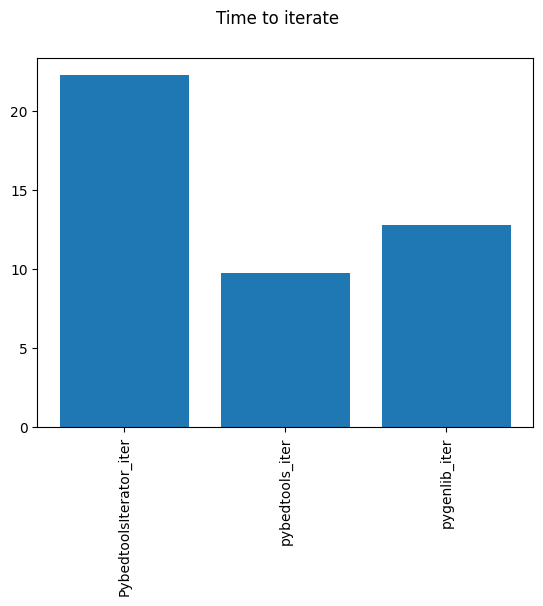

'For iterating+filtering 800000 items, The fastest method (82141.01514562813 it/s) is 1.314703577164709X'

'(31.470357716470907%) faster than pygenlib (62478.734044957506 it/s).'

In [58]:
times, data=Counter(),Counter()
bed_file= get_resource('pybedtools_snps')  
with Timer(times, 'pygenlib_iter') as timer:
    with BedIterator(bed_file, chromosome='chr21') as it:
        data[timer.name] = len([x for x in it])
        stats = it.stats()
with Timer(times, 'pybedtools_iter') as timer:
    data[timer.name] = len([x for x in pybedtools.BedTool(bed_file)])
with Timer(times, 'PybedtoolsIterator_iter') as timer:
    data[timer.name] = len([x for x in PybedtoolsIterator(pybedtools.BedTool(bed_file))])

# check results
assert len({y for y in data.values()})==1, f"Error in some computation: {data}"

# plot the data
labels, values = zip(*sorted(times.items()))
plt.bar(range(len(labels)), values, 0.8)
plt.xticks(range(len(labels)), labels)
plt.xticks(rotation=90)
plt.suptitle("Time to iterate")
plt.show()

n = stats[('yielded_items', None)]
speed_fastest = n/min(times.values())
speed_fastest = n/min(times.values())
speed_pygenlib = n/(times['pygenlib_iter'])

display(f"For iterating+filtering {n} items, The fastest method ({speed_pybedtools} it/s) is {speed_pybedtools/speed_pygenlib}X")
display(f"({(speed_pybedtools/speed_pygenlib-1)*100}%) faster than pygenlib ({speed_pygenlib} it/s).")

## Filtered iteration
Here we compare various methods for iterating a bed file and filtering for entries with a given minimum length.
We compare native pybedtools iterators with various filter options with pygenlib's BedIterator and the wrapped PybedtoolsIterator.
Note that this provides just approximate timings and there are many factors (CPU and I/O speed, etc.) that influence this.

WARN: Could not create refdict, is file bgzipped+tabixed? Unsupported input format for file /var/folders/1b/f_v7b42173763b830kvj5xdh0000gq/T/pybedtools.a48gxgn5.tmp
Filtered BED to create /var/folders/1b/f_v7b42173763b830kvj5xdh0000gq/T/pybedtools.a48gxgn5.tmp


'For iterating+filtering 800000 items, The fastest method (133978.43700658626 it/s) is 1.2693372084644972X'

'(26.933720846449717%) faster than pygenlib (105549.91700641823 it/s).'

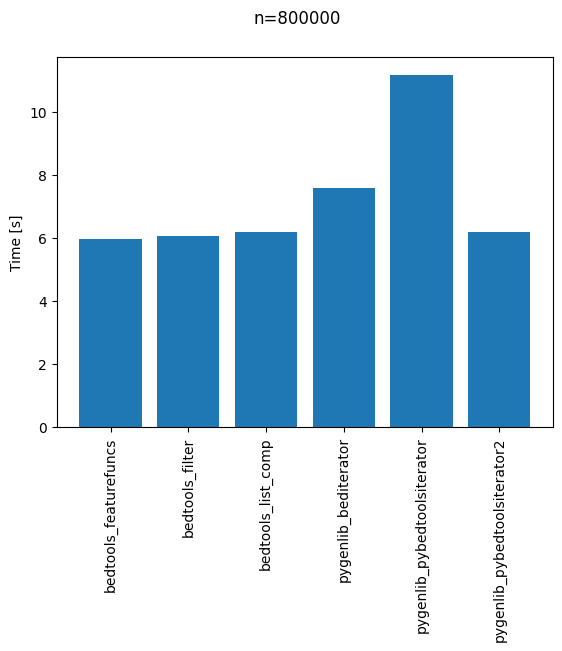

In [57]:
from pybedtools.featurefuncs import greater_than
stats,times,data=Counter(),Counter(),Counter()
with Timer(times, 'bedtools_filter') as timer:
    # BedTools with filter()
    data[timer.name] = [x.name for x in pybedtools.BedTool(get_resource("pybedtools_snps") ).filter(lambda x: len(x) > 1)]
with Timer(times, 'bedtools_list_comp') as timer:
    # BedTools with list comprehension
    data[timer.name] = [x.name for x in pybedtools.BedTool(get_resource("pybedtools_snps")) if len(x) > 1]
with Timer(times, 'bedtools_featurefuncs') as timer:
    # BedTools with filter()/featurefuncs
    data[timer.name] = [x.name for x in pybedtools.BedTool(get_resource("pybedtools_snps") ).filter(greater_than, 1)]
with Timer(times, 'pygenlib_bediterator') as timer:
    # native pygenlib iterator. Collect stats from here
    with BedIterator(get_resource("pybedtools_snps")) as it:
        data[timer.name] = [snp.data.name for snp in it if len(snp)>1]
        stats=it.stats
with Timer(times, 'pygenlib_pybedtoolsiterator') as timer:
    # pygenlib PybedtoolsIterator with list comprehension
    # This is the slowest option as we convert all intervals to GIs and then filter for length.
    # not recommended.
    data[timer.name] = [snp.data.name for snp in PybedtoolsIterator(get_resource("pybedtools_snps") ) if len(snp)>1]
with Timer(times, 'pygenlib_pybedtoolsiterator2') as timer:
    # here we first filter via pybedtools, save the file and then iterate via a PybedtoolsIterator
    bt=pybedtools.BedTool(get_resource("pybedtools_snps") ).filter(greater_than, 1).saveas()
    with PybedtoolsIterator(bt) as it:
        print(f"Filtered BED to create {bt.fn}")
        data[timer.name] = [snp.data.name for snp in it]

# check results
assert len({len(y) for y in data.values()})==1, f"Error in some computation: {data}"

# calc speed improvement
n = stats[('yielded_items', None)]
speed_fastest = n/min(times.values())
speed_pygenlib = n/times['pygenlib_bediterator']

display(f"For iterating+filtering {n} items, The fastest method ({speed_fastest} it/s) is {speed_fastest/speed_pygenlib}X")
display(f"({(speed_fastest/speed_pygenlib-1)*100}%) faster than pygenlib ({speed_pygenlib} it/s).")

# plot the timings
labels, values = zip(*sorted(times.items()))
plt.bar(range(len(labels)), values, 0.8)
plt.xticks(range(len(labels)), labels)
plt.xticks(rotation=90)
plt.ylabel("Time [s]")
plt.suptitle(f"n={n}")
plt.show()

## Potential pitfalls
In this section we demonstrate two common pitfalls that regularly hamper bioinformatics analyses leading to wrong results: 
- [unsorted input files](#Pybedtools-unsorted input-example) and 
- [wrongly interpreted coordinate systems](#bioframe-coordinate-mixup-example).

We showcase both problems below using realistic scenarios.
Notably, in both cases analyses run through and deliver plausible (yet wrong) results which makes these kinds of errors hard to catch.

### Pybedtools unsorted input example

Here, we demonstrate how unsorted input may lead to wrong analysis results using pybedtools.

The following code block was copy-pasted from the [pybedtools page](https://github.com/daler/pybedtools) and the idea of this example is to create a list of gene names that are <5 kb away from intergenic SNPs. However, this code does not work properly (with pybedtools v0.9.1) due to inconsistent chromosome order of the two input files (hg19.gff: chr1, chr21; snps.bed.gz: chr21, chr1; both are pybedtools test resources).

As a result, genes.closest reports only -1 as distance which is why all closes genes will be reported, not just the ones at max 5kb distance.
Notably, the code runs without errors/warnings and returns a reasonable-sized list of gene names which makes it hard to spot the error. 
Only when omitting the `stream=True flag`, genes.closest() fails and reports the inconsistent chrom order. 

Note, that in *pygenlib*, input files have to be bgzipped and indexed which requires them to be coordinate sorted and that reference dictionaries are used to ensure consistent chromosome ordering.

In [33]:
def run_pybedtools_example(gff_file, snp_file):
    snps = pybedtools.BedTool(snp_file)  
    genes = pybedtools.BedTool(gff_file)
    intergenic_snps = snps.subtract(genes).saveas()                      
    nearby = genes.closest(intergenic_snps, d=True, stream=True).saveas() 
    nbgenes = [gene.name for gene in nearby if int(gene[-1]) < 5000]
    display(f"We found {len(nbgenes)} nearby genes. Unique names: {len(set(nbgenes))}")


display("Unsorted input files:")
run_pybedtools_example(get_resource("pybedtools::hg19.gff"), get_resource("pybedtools::snps.bed.gz"))
display("Sorted input files:")
run_pybedtools_example(get_resource("pybedtools_gff"), get_resource("pybedtools_snps"))

'Unsorted input files:'

'We found 4217 nearby genes. Unique names: 4215'

'Sorted input files:'

'We found 2422 nearby genes. Unique names: 2419'

### Bioframe coordinate mixup example

In bioframe, interval coordinates are "[... assumed to be 0-based and intervals half-open (1-based ends) i.e. (start, end)](https://bioframe.readthedocs.io/en/latest/guide-definitions.html#definitions)" as, for example, in the BED file format.
However, this is not enforced or validated when reading genomic datasets in different formats which is why it is rather easy to make bioframe interpret 1-based as 0-base coordinates a demonstrated in the following snippet. 

This shifts start coordinates of misinterpreted datasets by 1bp and may lead to subtle errors in downstream analyses. 
Note, that *pygenlib* provides format-specific iterators that ensure proper coordinate interpretation which makes it harder (yet not impossible) to fall into this pit. 

In [57]:
# let's load a GFF file and a corresponding BED file with the bioframe.read_table() method (you can use igv to check they are representing the same intervals)
# the file was created with bedops gff2bed: "gff2bed -d < gencode_44.ACTB+SOX2.gff3 | cut -f1-6 | bgzip > gencode_44.ACTB+SOX2.bed.gz"
bioframe_gff = bioframe.read_table(get_resource("gencode_gff"), schema='gff')[['chrom','start','end', 'strand']]
bioframe_bed = bioframe.read_table(get_resource("gencode_bed"), schema='bed')[['chrom','start','end', 'strand']]
assert bioframe.is_bedframe(bioframe_gff) and bioframe.is_bedframe(bioframe_bed) # assert that they are 'bedframes'

# let's compare them using pandas compare...
display('bioframe:', bioframe_gff.compare(bioframe_bed))
# so we see that the start coordinates differ by one

# Now load via pygenlib
pygenlib_gff = pd.DataFrame([(loc.chromosome, loc.start, loc.end, loc.strand) for loc, info in GFF3Iterator(get_resource("gencode_gff"))],
                           columns=['chrom','start','end','strand'])
pygenlib_bed = pd.DataFrame([(loc.chromosome, loc.start, loc.end, loc.strand) for loc, info in BedIterator(get_resource("gencode_bed"))],
                           columns=['chrom','start','end','strand'])

display('pygenlib:', pygenlib_gff.compare(pygenlib_bed))
# no differences as expected as the BedIterator will convert the coordinates appropriately

'bioframe:'

start           
          self      other
0    180989762  180989761
1    180989770  180989769
2    180989770  180989769
3    180989771  180989770
4    180989773  180989772
..         ...        ...
340    5562574    5562573
341    5562574    5562573
342    5562574    5562573
343    5563714    5563713
344    5563714    5563713

[345 rows x 2 columns]

'pygenlib:'

Empty DataFrame
Columns: []
Index: []

### Mutable interval pitfalls

Another, more subtle, pitfall results from how genomic intervals and their annotations are implemented in the different python libraries.
In most cases, intervals are implemented as [mutable](https://realpython.com/python-mutable-vs-immutable-types/) objects whose values can be changed at runtime.
Often these interval objects also contain associated (mutable) meta-data (such as interval names, scores, etc.). 
This, however, means that updates of intervals or associated meta-data results in changes hash values of the respective objects as shown below.
This makes them unsafe to use as keys in referencing datastructures such as dicts and can lead to unwanted side-effects. 

In *pygenlib*, [genomic intervals](#Genomic-intervals) (locations) and their annotations are modeled separatedly with the former being implemented as [frozen (basically immutable) dataclasses](https://docs.python.org/3/library/dataclasses.html#frozen-instances) while the latter being stored in a dict-like datastructure that is indexed by the respective interval. 

The following codeblock demonstrates the different approaches.

In [75]:
i = pybedtools.Interval("chr1", 22, 44, strand='-') # create a pybedtools interval
i.name='A' # set a metadata attribute of this interval
cache = { i : 'interval found in cache.' } # put it in a dict
display(f"Now it's here: {cache.get(i, 'interval not found in cache!')} with hash value {i.__hash__()}")
i.name = 'B' # now we can just mutate the start coordinate, but this will change the hash value of this object
display(f"Now it isn't: {cache.get(i, 'interval not found in cache!')} with hash value {i.__hash__()}")

'Now its here: interval found in cache. with hash value -1715468265238973917'

"Now it isn't: interval not found in cache! with hash value -3006432686961990100"

In [79]:
i = gi("chr1", 22, 44, strand='-') # create a pygenlib interval
with pytest.raises(dataclasses.FrozenInstanceError):
    i.start = 21 # This will raise an 'FrozenInstanceError', you cannot mutate genomic intervals!
cache = { i : {'mess':'interval found in cache.', 'name':'A'} } # put it in a dict and add also the interval Name
display(f"Now it's here: {cache.get(i, 'interval not found in cache!')} with hash value {i.__hash__()}")
cache[i]['name']='B'
display(f"Now it's still here: {cache.get(i, 'interval not found in cache!')} with hash value {i.__hash__()}")


"Now it's here: {'mess': 'interval found in cache.', 'name': 'A'} with hash value -5667284585577806300"

"Now it's still here: {'mess': 'interval found in cache.', 'name': 'B'} with hash value -5667284585577806300"

## Other related work 

- [pyranges](https://pyranges.readthedocs.io/en/latest/index.html) is a python library for efficient and intuitive manipulation of genomic intervals
- [pygenomics](https://gitlab.com/gtamazian/pygenomics) is another general python genomics library
- [biopython](https://biopython.org/) is a general bioinformatics library and `pygenlib` provides a few utility functions (e.g., `align_sequence()`) based on biopython functionality
- [biocantor](https://biocantor.readthedocs.io/en/latest/) is another API targeted at transcriptomics analyses but it is unclear whether it is still supported.
- [BioNumPy](https://bionumpy.github.io/bionumpy/) A python library for efficient representation and analysis of biological data byuilt on top of NumPy
- [RNAlysis](https://guyteichman.github.io/RNAlysis/build/index.html) Python based RNA-seq analysis software 


# Case studies

In this section we present some more complex application scenarios for *pygenlib* theby showcasing the API and performance of our library.
Some of these case_studies need access to large genomics datasets (e.g., reference genomes) that should be cached locally. Respective download links are provided, file paths need to be updated manually after download.

## CTCF motif annotation with bioframe and pygenlib

In this example we use pygenlib to instantiate a human Transcriptome (canonical protein-coding transcripts on chromosome 2 only), download an  CTCF motif dataset with bioframe and annotate all transcripts with those motifs. We then report all genes/transcripts with at least one overlapping CTCF motif.
This example demonstrates how to use these two libaries together for maximum benefit.

We show two scenarios and compare their runtimes.

- scenario1
    - we instantiate a filtered pygenlib transcriptome
    - we then annotate with the JASPAR motifs loaded via bioframe
    - for annotation we use a custom callback method which is very flexible.
    - finally, we build a pandas dataframe with results containing one row per tx
- scenario2
    - we read the GFF with bioframe and correct the start coordinate due to the issue described above
    - we overlap tx and ctcf sites with the bioframe overlap method (NOTE that we cannot use the inner join as it would change the order of the ctcf sites)
    - we create a results dataframe while filtering for the respective transcripts. This is done base on GFF attributes parsed from the 'attributes' column.
    
Scenario1 is faster (probably due to early filtering) and more flexible in our opinion. 
In the callback annotation method users have access to genomic locations and all data attributes of transcripts and the overlapping CTCF motifs as well as external data. 
They are also free to chose the created annotation data structures (here a list of location/score tuples). Together, this enables the implementation of complex annotation scenarios.

Building transcriptome (Filtered (1 tags, 0 tids, 1 genetypes, 1 chroms, 0 regions).): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.59s/it]
Build interval tree: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1244/1244 [00:00<00:00, 36877.95it/s]


'Annotating transcriptome'

0it [00:00, ?it/s]
buf=[0]: : 1208it [00:01, 671.49it/s]                                                                                                                                                                 | 0/1 [00:00<?, ?it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.79s/it]
buf=[0]: : 1244it [00:01, 691.84it/s]


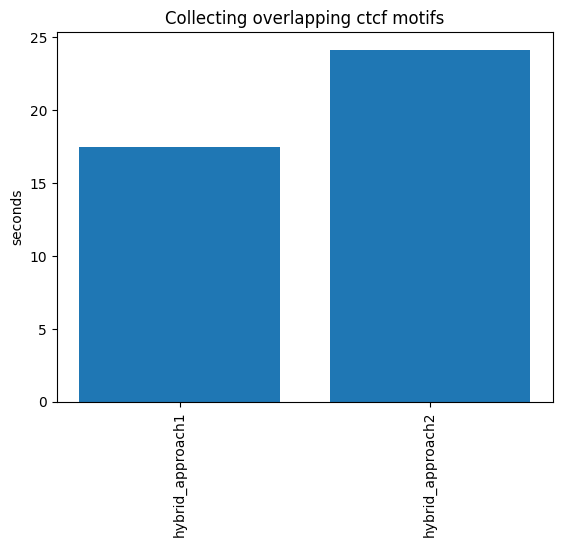

In [ ]:
from pygenlib.utils import parse_gff_attributes # needed to parse GFF attributes in the bioframe scenario

# please update paths accordingly
gencode_gff='/Volumes/groups/ameres/Niko/ref/genomes/GRCh38/annotation/gencode.v39.annotation.sorted.gff3.gz'
jaspar_uri='http://expdata.cmmt.ubc.ca/JASPAR/downloads/UCSC_tracks/2022/hg38/MA0139.1.tsv.gz'

# we use this for both approaches and do not time it. Here, itervals are correct
ssl._create_default_https_context = ssl._create_unverified_context # to avoid invalid certificate problems
ctcf = bioframe.read_table(jaspar_uri, schema='jaspar').query("chrom=='chr2' & pval>500")

times, results=Counter(),Counter()
with Timer(times, 'hybrid_approach1') as timer:
    # Build subset of human transcriptome (canonical protein coding genes on chrom 2)
    t=Transcriptome({
        'annotation_gff': gencode_gff,
        'annotation_flavour': 'gencode',
        'transcript_filter': {
            'included_tags': ['Ensembl_canonical'],
            'included_genetypes': ['protein_coding'],
            'included_chrom': ['chr2']
        }
    })
    # custom annotation method
    def anno_ctcf(item, label='ctcf_scores'):
        """ 
            Callback method for annotating transcripts.

            loc: genomic interval of the feature that is annotated
            anno: the transcriptome anno dict for this feature (so you can also access any other already existing annotations for this feature)
            dfrows: list of (loc, row) tuples containing all overlapping locations (loc) and the respective dataframe rows

            This method adds 'ctcf' annotations comprising of a list of (location, score) tuples that are overlapping the annotated transcript
        """
        loc, (anno, dfrows) = item
        if label not in anno:
            anno[label]=[]
        for sloc,dfrow in dfrows:
            anno[label].append((sloc,dfrow['score'])) # add ctcf motif annotations
    # anotate all transcripts using the above defined anno_ctcf method
    display("Annotating transcriptome")     
    t.annotate(iterators=BioframeIterator(ctcf), 
               fun_anno=anno_ctcf, 
               feature_types=['transcript'])
    # build dataframe of transcripts with at least one overlapping CTCF peak
    results[timer.name]= pd.DataFrame([(tx.parent.gene_name, 
                                        tx.feature_id,
                                        str(tx.location),
                                        ','.join([str(l) for l,_ in tx.ctcf_scores]),
                                        ','.join([str(s) for _,s in tx.ctcf_scores])) for tx in t.transcript.values() if len(tx.ctcf_scores)>0], 
                                      columns=['gene','tid','location','ctcf_locations','ctcf_scores'])

    
with Timer(times, 'hybrid_approach2') as timer:
    tx = bioframe.read_table(gencode_gff, schema='gff', comment='#').query("chrom=='chr2' & feature=='transcript'")
    tx['start']=tx['start']-1 # we need to correct start coordinates as bioframe coordinates are assumed to be 0-based and no correction is done (see above)
    over=bioframe.overlap(tx, ctcf, suffixes=('','_ctcf'), how='left', return_index=True) # NOTE: cannot use inner here as it will change order :/
    data={'gene':[], 'tid':[], 'location':[], 'ctcf_locations':[], 'ctcf_scores':[]}
    for loc, row in BioframeIterator(over):
        info = parse_gff_attributes(row['attributes']) # parse gff attributes from attributes column.
        if not info.get('gene_type', 'NA') == 'protein_coding':
            continue
        if 'Ensembl_canonical' not in info.get('tag','NA'):
            continue
        if pd.isnull(row['start_ctcf']): # filter tx w/o ctcf site
            continue
        data['gene'].append(info['gene_name'])
        data['tid'].append(info['transcript_id'])
        data['location'].append(str(loc))
        ctcf_loc = gi(row['chrom_ctcf'], row['start_ctcf']+1, row['end_ctcf'], strand=row['strand_ctcf'])
        data['ctcf_locations'].append(str(ctcf_loc)) # coorect coords
        data['ctcf_scores'].append(str(int(row['score_ctcf'])))
    df = pd.DataFrame.from_dict(data) # create dataframe
    df = df.groupby(['gene','tid','location'], sort=False).agg(','.join).reset_index() # colapse rows while keeping sort order
    results[timer.name]=df

plot_times(f"Collecting overlapping ctcf motifs",
       times, our_method='hybrid_approach1', show_speed=False)

# assert that1'].compare(results['hybrid_approach2']).index)==0 we get same results
assert len(results['hybrid_approach

## Read mismatch analysis
In this example we are showcasing the ReadIterator's `report_mismatches` feature which reports reference/read mismatches (possibly filtered by minimum basecalling quality). Briefly, we do the following:

- iterate over alignment and report mismatches, so returned item.data is a tuple (read, mismatches)
- ref/alt alleles are revcomped if read is reversed (strand specific)
- count and plot results

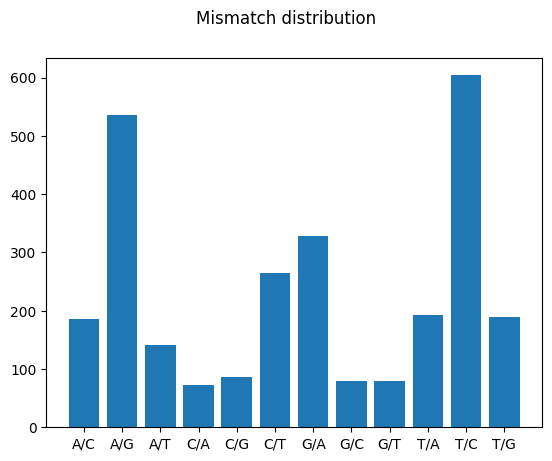

In [44]:
# Calculate mismatch profile and plot. 
profile=Counter()
for l,(r,mm) in ReadIterator(get_resource('small_example_bam'),report_mismatches=True, min_base_quality=10):
    is_rev = not r.is_reverse if r.is_read2 else r.is_reverse # properly deal with PE data
    for (readpos, genpos, ref, alt) in mm: # reported mismatches contain position in read, genomic position, reference and alternate allele
        if is_rev: # correct for read strand
            ref,alt=reverse_complement(ref),reverse_complement(alt)
        profile[f"{ref}/{alt}"]+=1
# plot the data
labels, values = zip(*sorted(profile.items()))
plt.bar(range(len(labels)), values, 0.8)
plt.xticks(range(len(labels)), labels)
plt.suptitle("Mismatch distribution")
plt.show()

Using this feature, we  can  also easily count mismatches of a certain type (e.g., T/C mismatches as found in a SLAMseq dataset)

In [45]:
# count t/c mismatches per read in a BAM file, filtering for minimum base quality
tc_conv={}
for l,(r,mm) in ReadIterator(get_resource('small_example_bam'),report_mismatches=True, min_base_quality=10):
    if len(mm)>0: # at least 1 mismatch - just to speed things up.
        is_rev = not r.is_reverse if r.is_read2 else r.is_reverse
        refc = "A" if is_rev else "T"
        altc = "G" if is_rev else "C"
        mm_tc=[(off, pos1, ref, alt) for off, pos1, ref, alt in mm if ref==refc and alt==altc] # get only T/C or A/G mismatches (depending on read strand)
        if len(mm_tc) > 0: # at least 1 T/C or A/G mm
            tc_conv[r.query_name, not r.is_read2]=mm_tc

# show the first 10 reads
display('10 reads and their mismatches', {k:tc_conv[k] for k in list(tc_conv.keys())[:10]}, SEP)

# count reads with more than one T/C conversion
display('Number of reads with more than one T/C conversion', len({k:tc_conv[k] for k in list(tc_conv.keys()) if len(tc_conv[k])>1}),SEP)

# show MM of one such read
display('Example read with 2 mismatches:', tc_conv['HWI-ST466_135068617:8:2316:4251:54002', False],  SEP)

'10 reads and their mismatches'

{('HWI-ST466_135068617:8:1104:18372:89212', False): [(2, 22379204, 'A', 'G')],
 ('HWI-ST466_135068617:8:2114:8986:54547', False): [(98, 22404991, 'T', 'C')],
 ('HWI-ST466_135068617:8:2214:18036:44964', False): [(86, 22404981, 'A', 'G')],
 ('HWI-ST466_135068617:8:2301:15221:88708', True): [(71, 22404968, 'A', 'G')],
 ('HWI-ST466_135068617:8:1107:12866:40944', False): [(72, 22404971, 'A', 'G')],
 ('HWI-ST466_135068617:8:2101:20690:68324', False): [(78, 22404984, 'A', 'G')],
 ('HWI-ST466_135068617:8:1102:11736:16410', True): [(53, 22404966, 'T', 'C')],
 ('HWI-ST466_135068617:8:1103:20561:79535', True): [(52, 22404966, 'T', 'C')],
 ('HWI-ST466_135068617:8:2308:21226:40688', False): [(25, 22404940, 'A', 'G')],
 ('HWI-ST466_135068617:8:1303:15014:31681', False): [(2, 22379925, 'A', 'G')]}

---

'Number of reads with more than one T/C conversion'

25

---

'Example read with 2 mismatches:'

[(2, 22443997, 'A', 'G'), (5, 22444000, 'A', 'G')]

---

Now, we slightly extend this simple example by

- counting only T/C (A/G on reverse strand) mismatches per chromosome
- count also the number of unconverted (i.e., ref==T) positions
- Create a pandas dataframe with these counts and filter rows for minimum couts
- Show a filtered dataset of entries with 20-22 convertible positions, the number of converted positions and the number of such reads  found

In [46]:
# Count T/C (A/G) mismatches per chromosome.
bam_file=get_resource('small_example_bam')
profile=Counter()
for l,(r,mm) in tqdm(ReadIterator(bam_file,report_mismatches=True, min_base_quality=10), total=sum([x.total for x in open_file_obj(bam_file).get_index_statistics()])):
    is_rev = not r.is_reverse if r.is_read2 else r.is_reverse
    refc = "A" if is_rev else "T"
    altc = "G" if is_rev else "C"
    for (readpos, genpos, ref, alt) in mm:
        n_ref = r.query_sequence.count(refc)
        mm_tc=[(off, pos1, ref, alt) for off, pos1, ref, alt in mm if ref==refc and alt==altc]
        profile[r.reference_name,refc,altc,n_ref,len(mm_tc)]+=1
# filter for min number of counts
profile=pd.DataFrame([list(k)+[v] for k,v in profile.items()], columns=['chromosome','ref','alt', 'convertible','converted', 'count'])
profile=profile[profile['count']>10]

# show filtered data, grouped by strand and convertible positions
fil=profile.query('20 <= convertible <= 22').sort_values(['convertible', 'converted'])
fil['conv']=fil['ref']+"/"+fil['alt']
grouped=fil.groupby(['conv', 'convertible'])
for i, key in enumerate(grouped.groups.keys()):
    dat=grouped.get_group(key).set_index('conv')
    display(dat)

 69%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 21932/31678 [00:00<00:00, 37707.05it/s]


,chromosome,ref,alt,convertible,converted,count
conv,,,,,,
A/G,1,A,G,20,0,41


,chromosome,ref,alt,convertible,converted,count
conv,,,,,,
A/G,1,A,G,21,0,37


,chromosome,ref,alt,convertible,converted,count
conv,,,,,,
A/G,1,A,G,22,0,50
A/G,1,A,G,22,1,11


,chromosome,ref,alt,convertible,converted,count
conv,,,,,,
T/C,1,T,C,20,0,21


,chromosome,ref,alt,convertible,converted,count
conv,,,,,,
T/C,1,T,C,21,0,44
T/C,1,T,C,21,1,44
T/C,1,T,C,21,2,14


,chromosome,ref,alt,convertible,converted,count
conv,,,,,,
T/C,1,T,C,22,0,58
T/C,1,T,C,22,1,41


Please note that such an analysis can easily be combined with the transcriptome annotation scenario shown below, e.g., to count converted reads per transcript/exon.

## shRNA guide example

In this small case study we will do the following:
    
- create a subset of the human transcriptome and load the gene sequences
- create a random list of shRNA guide sequences (in a real scenario those would, e.g., predicted by some external tool)
- create a pandas dataframe containing 
    - the guide sequence 
    - a list of transcript ids that contain this guide (exact match) in their spliced RNA sequence
    - a list of gene ids for these transcripts
- filter guides that are not found or that target multiple genes
- check for untargeted transcripts of the targeted genes

Please note that the code in this case study is not optimized and is more explicit than necessary in order to showcase the API and make the example easier to understand. 

*Required resources:*
- Human genome FASTA (GRCh38), accessible at https://www.ncbi.nlm.nih.gov/datasets/genome/GCF_000001405.26/
- Full gencode annotation gff3 file (sorted), available at https://www.gencodegenes.org/human/

In [53]:
# please update paths accordingly
grch38_fasta='/Volumes/groups/ameres/Niko/ref/genomes/GRCh38/GCA_000001405.15_GRCh38_full_plus_hs38d1_analysis_set.fna'
gencode_gff='/Volumes/groups/ameres/Niko/ref/genomes/GRCh38/annotation/gencode.v39.annotation.sorted.gff3.gz'

# Build subset of human transcriptome (chr20)
config={
    'genome_fa': grch38_fasta,
    'annotation_gff': gencode_gff,
    'annotation_flavour': 'gencode',
    'transcript_filter': {
        'included_chrom': ['chr20']
    },
    'copied_fields': ['gene_type'],
    'load_sequences': True
}
t=Transcriptome(config)
display(t)

WARN: Input list have differing order of shared elements ['chr1', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr2', 'chr20', 'chr21', 'chr22', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chrM', 'chrX', 'chrY']


Building transcriptome (Filtered (0 tags, 0 tids, 0 genetypes, 1 chroms, 0 regions).): 100%|████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.70s/it]
Build interval tree: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1480/1480 [00:00<00:00, 34400.12it/s]


Transcriptome with 1480 genes and 5822 tx (+seq)

In [54]:
# create a random set of shRNA guides of length 10. In a real scenario those would, e.g., be predicted by some external tool.
# Here, we use rnd_seq, a convenience pygenlib method, to create 3 random guide sequences with low GC%. 
random.seed(0) # if you change this, different random sequences will be created
guides=rnd_seq(10, 'GC'* 30 + 'AT' * 70, 20) 
print(guides)

['AATGAAATTA', 'TTCTCACTGA', 'AAAACTCAGT', 'AATCATAATG', 'TATTACACCA', 'ATTAGAATAA', 'TAGGTGTGTA', 'CGTATCTTAA', 'CATAGAAATT', 'CAATTTACGC', 'GAAATCGTTC', 'GCGTAAAAAA', 'TACTATAATA', 'TATTCTACAA', 'TTGAGTTCAG', 'TCTTCCCAGC', 'AAAAAGGCAG', 'TTGACACCTC', 'CCTCACACTC', 'TAACACGGTT']


In [55]:
# now we search for transcripts that contain respective kmers in their spliced RNA seq. 
# To make this fast, we first search for the kmer in the respective gene sequence (candidate_genes) and for those
# check all spliced tx sequences (overlapping_tx).
# Finally, we are interested whether some guides bind RNAs from multiple genes and create a set of gene ids for the overlapping genes (overlapping_genes).
# We combine the results in a pandas dataframe
d=[]
for guide in tqdm(guides, total=len(guides), desc='analyzing guide'):
    candidate_genes={g for g in t.genes if guide in g.sequence}
    overlapping_tx={tx for g in candidate_genes for tx in g.transcript if guide in tx.spliced_sequence}
    overlapping_genes={tx.parent.feature_id for tx in overlapping_tx}
    d.append(
        {
            'guide_seq': guide,
            'gids': ','.join(overlapping_genes),
            'n_gids': len(overlapping_genes),
            'tids': ','.join([tx.feature_id for tx in overlapping_tx])
        }
    )
df=pd.DataFrame(d)
display(df.head(8))

analyzing guide: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  6.45it/s]


,guide_seq,gids,n_gids,tids
0,AATGAAATTA,"ENSG00000289072.1,ENSG00000089048.15,ENSG00000...",9,"ENST00000266069.5,ENST00000688325.1,ENST000006..."
1,TTCTCACTGA,"ENSG00000101298.15,ENSG00000286087.1,ENSG00000...",3,"ENST00000381873.7,ENST00000651029.1,ENST000006..."
2,AAAACTCAGT,"ENSG00000196074.13,ENSG00000101109.12,ENSG0000...",3,"ENST00000377306.5,ENST00000451767.6,ENST000004..."
3,AATCATAATG,"ENSG00000054796.13,ENSG00000276627.3",2,"ENST00000494972.1,ENST00000666054.1,ENST000003..."
4,TATTACACCA,ENSG00000088930.8,1,ENST00000377191.5
5,ATTAGAATAA,ENSG00000101126.18,1,ENST00000371602.9
6,TAGGTGTGTA,"ENSG00000228293.1,ENSG00000125868.16",2,"ENST00000246069.12,ENST00000418739.1"
7,CGTATCTTAA,,0,


In [56]:
# In the DF above, we can see that some guides (e.g., CGTATCTTAA) are not found (no gids) while some target multiple 
# genes (e.g., AATGAAATTA). This is expected here as we generate short (10bp) sequences with low GC%/sequence complexity
# that are likely found in many genomic locations. In a real scenario, one would expect few such cases for guides predicted by SOTA tools.
# We continue the analysis by filtering those bad guides...
fil=df[df['n_gids']==1].copy() 
display(fil)

,guide_seq,gids,n_gids,tids
4,TATTACACCA,ENSG00000088930.8,1,ENST00000377191.5
5,ATTAGAATAA,ENSG00000101126.18,1,ENST00000371602.9
10,GAAATCGTTC,ENSG00000149609.6,1,ENST00000375222.4
12,TACTATAATA,ENSG00000088812.18,1,ENST00000262919.10
14,TTGAGTTCAG,ENSG00000172264.18,1,ENST00000490428.5


In [57]:
# ...and now we want to check for the remaining ones whether all tx of the respective genes are targeted.
# For this, we query the transcriptome for sets of transcript ids annotated for a given gene and use the pygenlib cmp_sets() method 
# to get shared and unique items when comparing to the set of transcript ids we found to be targeted by each guide.
# Finally, we add the number of missed (untargeted) transcripts and the respective gene names to the dataframe.
missed_tx, gene_names=[],[]
for guide, gid, tids in zip(fil['guide_seq'], fil['gids'], fil['tids']):
    all_tid={tx.feature_id for tx in t.gene[gid].transcript}
    found_tids=set(tids.split(','))
    s,m,w=cmp_sets(all_tid, found_tids)
    missed_tx.append(f"{len(m)}/{len(all_tid)}")
    gene_names.append(t.gene[gid].gene_name)
    assert len(w)==0, "We should not find a tx that was not found before"
fil['missed_tx']=missed_tx
fil['gene_name']=gene_names
display(fil)

,guide_seq,gids,n_gids,tids,missed_tx,gene_name
4,TATTACACCA,ENSG00000088930.8,1,ENST00000377191.5,0/1,XRN2
5,ATTAGAATAA,ENSG00000101126.18,1,ENST00000371602.9,8/9,ADNP
10,GAAATCGTTC,ENSG00000149609.6,1,ENST00000375222.4,1/2,C20orf144
12,TACTATAATA,ENSG00000088812.18,1,ENST00000262919.10,1/2,ATRN
14,TTGAGTTCAG,ENSG00000172264.18,1,ENST00000490428.5,15/16,MACROD2


We can see that we are not targetting all annotated transcripts except for XRN2 (which has only 1 tx).
In a real scenario, we would possssibly do such a check only on tx that are actually expressed in the respective
cells. 

## Transcriptome annotation

In this more complex example we will filter and visualize genomic features by read mappability 

Briefly, we will do the following:
- build a transcriptome of canonical protein coding genes (chr20) from gencode annotations
- annotate all gene annotations with a large (3.1G) bedgraph file containing umap mappability values.
- store the results in a pickle file so we can quickly reload later
- Query some of the data and demonstrated the slice_from_parent() functionality
- Visualize some of the data with matplotlib

*Required resources:*
- Human genome FASTA (GRCh38), accessible at https://www.ncbi.nlm.nih.gov/datasets/genome/GCF_000001405.26/
- Full gencode annotation gff3 file (sorted), available at https://www.gencodegenes.org/human/
- Full GRCh38.k24.umap mappability bedgraph file, available at https://bismap.hoffmanlab.org/

In [52]:
# please update paths accordingly
grch38_fasta='/Volumes/groups/ameres/Niko/ref/genomes/GRCh38/GCA_000001405.15_GRCh38_full_plus_hs38d1_analysis_set.fna'
gencode_gff='/Volumes/groups/ameres/Niko/ref/genomes/GRCh38/annotation/gencode.v39.annotation.sorted.gff3.gz'
bedgraph_file='/Volumes/groups/ameres/Niko/ref/genomes/GRCh38/mappability/GRCh38.k24.umap.bedgraph.gz'

config={
    'genome_fa': grch38_fasta,
    'annotation_gff': gencode_gff,
    'annotation_flavour': 'gencode',
    'transcript_filter': {
        'included_tags': ['Ensembl_canonical'],
        'included_genetypes': ['protein_coding'],
        'included_chrom': ['chr20']
    },
    'copied_fields': ['gene_type'],
    'drop_empty_genes': False,
    'load_sequences': False
}
# Build subset of human transcriptome (all protein coding genes, Ensembl canonical only), takes ~2min on CLIP
t=Transcriptome(config)
display(t)

WARN: Input list have differing order of shared elements ['chr1', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr2', 'chr20', 'chr21', 'chr22', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chrM', 'chrX', 'chrY']


Building transcriptome (Filtered (1 tags, 0 tids, 1 genetypes, 1 chroms, 0 regions).): 100%|████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.45s/it]
Build interval tree: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 546/546 [00:00<00:00, 45990.36it/s]


Transcriptome with 546 genes and 546 tx

Now, we annotate all genes with a numpy array containing the respective mappability values. 
This enables efficient slicing of child-intervals (e.g., transcripts, exons).


In [53]:
#%%timeit -n 1 -r 1
import numpy as np
# Example code that calculates a numpy array containing mappability values for each genomic position of the passed genomic feature (anno).
# The respective values are then saved (pickled) to the given output file
# if the output file already exists, values will be loaded from there istead of recalculating them.

def anno_scores(item, label='mappability'):
    """ 
        Callback method for creating the mappability array by slicing all overlapping intervals.
        loc: genomic interval of the feature that is annotated
        anno: the transcriptome anno dict for this feature (so you can also access any other already existing annotations for this feature)
        scores: list of (loc, score) tuples containing all overlapping locations (loc) and their scores as read from the bedgraph file.
    """
    loc, (anno, scores) = item
    anno[label]=np.zeros(len(loc)) # create empty array
    for sloc,score in scores:
        anno[label][range(max(loc.start, sloc.start)-loc.start, min(loc.end,sloc.end)+1-loc.start)]=score # update scores

# to speed things up, we cache the transcriptome annotations in a pickle file and reload from there if this file exists
pkfile='/Volumes/groups/ameres/Niko/ref/genomes/GRCh38/annotation/gencode.v39.k24.umap.genes.chr20.pk' 


if os.path.isfile(pkfile): 
    t.load_annotations(pkfile) # load from pickle file if existing; use update=True to not lose any previously annotated values 
else:
    roi=gi.from_str('chr20') # annotate all; here you could provide a genomic interval to restrict what features should be annotated
    #annotate genes with mappability scores
    t.annotate(iterators=BedGraphIterator(bedgraph_file, region=roi), 
               region=roi,
               fun_anno=anno_scores,
               feature_types=['gene'])
    t.save_annotations(pkfile, keys={'mappability'}) # save only the mappability values to disk.

# show an estimate of the memory consumption (for the whole genome this is ~10GB so it might make sense 
# to calculate mean/median mappability per annotation instead of keeping all values)
print(f"Memory size of the create numpy arrays: {sum([a['mappability'].nbytes for a in t.anno.values() if 'mappability' in a]) / (1000*1000*1000) } GB")

Loading annotations from /Volumes/groups/ameres/Niko/ref/genomes/GRCh38/annotation/gencode.v39.k24.umap.genes.chr20.pk
Memory size of the create numpy arrays: 0.238229856 GB


Now, let's query some data

In [54]:
display(t.genes[5].mappability) # direct access to array of mappability values. Safer to user .get('attr', default-value)
display(t.genes[5].transcript[0].get('mappability')) # no values assigned to tx: returns None
display(t.genes[5].transcript[0].get('mappability', default_value=[])) # no values assigned to tx: returns configured default value
# with slice_from_parent=T, pygenlib assumes that the attribute refers to an array that directly corresponds to the 
# genomic coordinates of a feature. It then searches for this array in the feature hierarchy (e.g., exon->tx->gene) and, 
# if found in a super-feature, slices the values from there.
display(t.genes[5].transcript[0].exon[0].get('mappability', slice_from_parent=True)) 

array([1.   , 1.   , 1.   , ..., 0.417, 0.458, 0.5  ])

None

[]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [57]:
# query example: 
# calculate mean exon mappability by slicing values from their parent genes and calculating the mean
# NOTE that the bedgraph file does not contain data for chrM and chrY (see tabix -l <file>), so for these we use the default value [] (relevant only for whole-genome analyses)
ex_map=[(ex, np.mean(ex.get('mappability', default_value=[], slice_from_parent=True))) for ex in t.__iter__(feature_types='exon')]
# get all exons with 0 mappability 
zero_map_ex=[ex for ex,mean_map in ex_map if mean_map==0]
# now show 10 random genes that contain at least 1 exon with zero mappability
display(f"There are {len(zero_map_ex)}/{len(ex_map)} exons with 0 mappability. Here are the respective gene names: { list({ex.parent.parent.gene_name for ex in zero_map_ex}) }")

"There are 1/5200 exons with 0 mappability. Here are the respective gene names: ['TASP1']"

Now, lets plot the data 

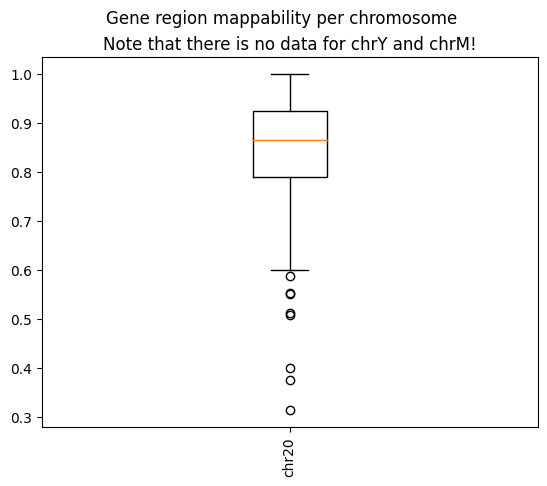

In [56]:
# calculate mean mappability per gene and plot 
mean_map=[[np.mean(g.get('mappability',[0])) for g in t.genes if g.chromosome==c] for c in t.merged_refdict]
_=plt.boxplot(mean_map)
_=plt.xticks([x+1 for x in range(len(t.merged_refdict))], list(t.merged_refdict.keys()), rotation=90)
_=plt.suptitle("Gene region mappability per chromosome")

## Gene annotation comparison
In this example, we compare two human gene annotation sets, namely gencode (v39) and chess (v3.0.1).
We load all protein_coding genes located on chr20 from both annotation sets, update the gene-names to their latest given symbol and compare both lists. We then exemplary show how to further analyze differences between those gene annotation sets.

*Required resources:*
- Human genome FASTA (GRCh38), accessible at https://www.ncbi.nlm.nih.gov/datasets/genome/GCF_000001405.26/
- Full gencode annotation gff3 file (sorted), available at https://www.gencodegenes.org/human/
- Full chess 3.0.1 annotation gff3 file (sorted), available at https://github.com/chess-genome/chess/releases/download/v.3.0.1/chess3.0.1.gff.gz


In [ ]:
grch38_fasta='/Volumes/groups/ameres/Niko/ref/genomes/GRCh38/GCA_000001405.15_GRCh38_full_plus_hs38d1_analysis_set.fna'
gencode_gff='/Volumes/groups/ameres/Niko/ref/genomes/GRCh38/annotation/gencode.v39.annotation.sorted.gff3.gz'
chess_gff='/Volumes/groups/ameres/Niko/ref/genomes/GRCh38/annotation/chess3.0.1.sorted.gtf.gz'

# Load gencode and chess annotation data and build subset of chr20 protein-coding genes
config={
    'genome_fa': grch38_fasta,
    'annotation_gff': gencode_gff,
    'annotation_flavour': 'gencode',
    'transcript_filter': {
        'included_chrom': ['chr20'],
        'included_genetypes': ['protein_coding']
    },
    'copied_fields': ['gene_type'],
    'drop_empty_genes': False,
    'load_sequences': False
}
t_gc=Transcriptome(config)
config={
    'genome_fa': grch38_fasta,
    'annotation_gff': chess_gff,
    'annotation_flavour': 'chess',
    'transcript_filter': {
        'included_chrom': ['chr20'],
        'included_genetypes': ['protein_coding']
    },
    'copied_fields': ['gene_type'],
    'drop_empty_genes': False,
    'load_sequences': False
}
# Build subset of chr20 transcripts 
t_ch=Transcriptome(config)
# compare
display(SEP)
display(t_gc)
display(t_ch)

In [59]:
# We use genenames.org data to convert old gene symbols to their current symbol.
# first, we download the current HGNC set into a file in a temporary directory (will be removed if context manager is closed)
# See below for more details on this fuctionality.
with tempfile.TemporaryDirectory() as tempdirname:
    gene_name_alias_file=download_file("https://ftp.ebi.ac.uk/pub/databases/genenames/hgnc/tsv/hgnc_complete_set.txt", f"{tempdirname}/hgnc_complete_set.txt")
    # now we read an alias table and a set of current gene symbols from this file.
    print(f"Loading gene aliases from {gene_name_alias_file}")
    aliases, current_symbols = read_alias_file(gene_name_alias_file)

Loading gene aliases from /var/folders/1b/f_v7b42173763b830kvj5xdh0000gq/T/tmp24zir13d/hgnc_complete_set.txt


load gene aliases: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 43736/43736 [00:02<00:00, 15867.90it/s]


In [60]:
# lets have a look at the shared and unique (normalized) gene symbols:
gn_gc={norm_gn(x.gene_name, current_symbols, aliases) for x in t_gc.genes}
gn_ch={norm_gn(x.gene_name, current_symbols, aliases) for x in t_ch.genes}
shared, uniq_gc, uniq_ch = cmp_sets(gn_gc, gn_ch) # cmp_sets is a pygenlib utility function for set comparison
display(f"Shared: {len(shared)}, only in gencode: {len(uniq_gc)}, only in chess: {len(uniq_ch)}")

'Shared: 523, only in gencode: 21, only in chess: 12'

In [61]:
# So most genes are annotated in both sets as expected but there are some unique entries too.
# lets display the unique gene names for genocde and chess:
print(uniq_gc)
display(SEP)
print(uniq_ch)
display(SEP)
# Most unique genecode genes have no given name but an ensembl gene id (starting with ENSG), while most unique chess genes start with “LOC” which 
# indicates and unknown function.
# Let's have a look at 'GCNT7' which is only annotated in gencode (https://www.genecards.org/cgi-bin/carddisp.pl?gene=GCNT7)
# We query the chess annotatoin set for the coordinates of the GCNT7 gene in the gencode annotation:
display([(x.location, x.gene_name, x.strand) for x in t_ch.query(t_gc.gene['GCNT7'], feature_types=['gene'])])
# Indeed, it shows only RTF2 and 'FAM209A', both on the opposite strand.
display(SEP)
# vice versa, we look at 'MMP24-AS1-EDEM2' which is found only in the chess annotation
display([(x.location, x.gene_name, x.strand) for x in t_gc.query(t_ch.gene['MMP24-AS1-EDEM2'], feature_types=['gene'])])


{'ENSG00000286235', 'ENSG00000273047', 'MTRNR2L3', 'RTEL1-TNFRSF6B', 'STX16-NPEPL1', 'ENSG00000270299', 'ENSG00000272897', 'ENSG00000260861', 'ENSG00000288000', 'ENSG00000274322', 'ENSG00000277611', 'HMGB1P1', 'ENSG00000261582', 'SYS1-DBNDD2', 'GCNT7', 'ENSG00000286022', 'ENSG00000241690', 'ENSG00000284776', 'ENSG00000273154', 'ENSG00000285382', 'ENSG00000256566'}


---

{'LOC124904962', 'LOC105372704', 'CHS.160570', 'LOC124904942', 'LOC124904970', 'LOC124904930', 'LOC124904958', 'LOC124904950', 'LOC124904903', 'MMP24-AS1-EDEM2', 'LOC124904927', 'LOC101929937'}


---

[(chr20:56468627-56519449 (+), 'RTF2', '+'),
 (chr20:56524744-56526152 (+), 'FAM209A', '+')]

---

[(chr20:35115364-35147336 (-), 'EDEM2', '-'),
 (chr20:35172072-35216240 (+), 'PROCR', '+'),
 (chr20:35201745-35278131 (-), 'MMP24OS', '-'),
 (chr20:35226690-35276998 (+), 'MMP24', '+'),
 (chr20:35267885-35280043 (-), 'ENSG00000261582', '-')]

# Utility functions

_Pygenlib_ also contains a number of utility functions which might be useful for handling genomics data. Some of those functions were demonstrated already in the context of this notebook. Here we present and document them in more detail:

In [31]:
# Gene symbols are updated regularly and mapping between different id schemas is cumbersome
# pygenlib implements an interface to MyGeneInfo for easy translation between ids and symbols 
# Example: we pass a mixed list of Ensembl and Entrez ids for mouse and human  actin beta:
geneid2symbol(['ENSMUSG00000029580', 60])

INFO:biothings.client:querying 1-2...
INFO:biothings.client:done.


{'ENSMUSG00000029580': Actb (actin, beta, tax: 10090),
 '60': ACTB (actin beta, tax: 9606)}

In [32]:
# Here we use genenames.org data to convert lists containing partially old gene symbols to their current symbol
# first, we download the current HGNC set into a file in a temporary directory (will be removed if context manager is closed)
with tempfile.TemporaryDirectory() as tempdirname:
    gene_name_alias_file=download_file("https://ftp.ebi.ac.uk/pub/databases/genenames/hgnc/tsv/hgnc_complete_set.txt", f"{tempdirname}/hgnc_complete_set.txt")
    # now we read an alias table and a set of current gene symbols from this file.
    print(f"Loading gene aliases from {gene_name_alias_file}")
    aliases, current_symbols = read_alias_file(gene_name_alias_file)
    # now lets translate some previous names of AADAC
    display(norm_gn('DAC', current_symbols, aliases), norm_gn('CES5A1', current_symbols, aliases))

Loading gene aliases from /var/folders/1b/f_v7b42173763b830kvj5xdh0000gq/T/tmp6n3btn7h/hgnc_complete_set.txt


load gene aliases: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 43736/43736 [00:03<00:00, 14046.42it/s]


'AADAC'

'AADAC'

In [37]:
# We also provide a wrapper around some *Biopython* methods, e.g., for sequence alignment
refseq='AAATTTCCCACTGAAATTTCCC'
score, startpos, endpos, aln = align_sequence('ACTGactTTTC', refseq, report_alignment=True)
print(f"We found a match from {startpos}-{endpos} ('{'AAATTTCCCACTGAAATTTCCC'[startpos:endpos]}') with normalized alignment score {score}")
display_textarea(aln)

We found a match from 9-20 ('ACTGAAATTTC') with normalized alignment score 0.7272727272727273


In [4]:
# And utilities to work with Nanopore data (FAST5 files)
# You can, e.g., inspect the structure of such a file:
fast5_file=get_resource('nanoseq_fast5_raw')
print_fast5_tree(fast5_file, show_attrs=False)

Raw └── Reads
Raw     └── Read_205344 {duration=21211,median_before=217.6046905517578,read_id=b'003c04de-f704-491e-8d0c-33ffa269423d',read_number=205344,start_mux=4,start_time=364905104}
Raw         └── Signal
---


In [5]:
# Or list the basecalling groups in this file
fast5_file=get_resource('nanoseq_fast5_basecalled')#'testdata/fast5/FAT61995_a1291c8f_5.fast5'
get_bcgs(fast5_file)

['Basecall_1D_000']